In [1]:
import cPickle
import string
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import gc
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import model_eval

%matplotlib inline

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
DATA_TRAIN_PATH = '../input/train.csv'
DATA_TEST_PATH = '../input/test.csv'
LIN_DATA_TRAIN_PATH = '../input/lin_train.csv'
LIN_DATA_TEST_PATH = '../input/lin_test.csv'
IMG_PATH = '../images/'

### These variables perform better with OHE
ohe_list = ['cat73', 'cat93', 'cat112']

### These dicts are to re-encode cat112 to state abbreviations
swap_to_num = {'cat112': {'A': 0, 'AA': 25, 'AB': 26, 'AC': 27, 'AD': 28,
'AE': 29, 'AF': 30, 'AG': 31, 'AH': 32, 'AI': 33, 'AJ': 34, 'AK': 35, 'AL': 36,
'AM': 37, 'AN': 38, 'AO': 39, 'AP': 40, 'AQ': 41, 'AR': 42, 'AS': 43, 'AT': 44,
'AU': 45, 'AV': 46, 'AW': 47, 'AX': 48, 'AY': 49, 'B': 1, 'BA': 50, 'C': 2,
'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11,
'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}}

swap_to_state = {'cat112': {0: 'AL', 1: 'AK', 2: 'AZ', 3: 'AR', 4: 'CA',
5: 'CO', 6: 'CT', 7: 'DE', 8: 'DC', 9: 'FL', 10: 'GA', 11: 'HI', 12: 'ID',
13: 'IL', 14: 'IN', 15: 'IA', 16: 'KS', 17: 'KY', 18: 'LA', 19: 'ME', 20: 'MD',
21: 'MA', 22: 'MI', 23: 'MN', 24: 'MS', 25: 'MO', 26: 'MT', 27: 'NE', 28: 'NV',
29: 'NH', 30: 'NJ', 31: 'NM', 32: 'NY', 33: 'NC', 34: 'ND', 35: 'OH', 36: 'OK',
37: 'OR', 38: 'PA', 39: 'RI', 40: 'SC', 41: 'SD', 42: 'TN', 43: 'TX', 44: 'UT',
45: 'VT', 46: 'VA', 47: 'WA', 48: 'WV', 49: 'WI', 50: 'WY'}}

### Helper functions
def convert_cat_to_num(data):
    translation = list(string.ascii_uppercase)[:-1]
    for elem_i in translation[:13]:
        for elem_j in translation[:25]:
            translation.append(elem_i + elem_j)
    for i in range(len(translation)):
        data.replace(translation[i], i, inplace=True)
    data.replace('ZZ', -1, inplace=True)
    return

In [3]:
### Read the data in and prepare
log_y = 436.28279443805883
train = pd.read_csv(LIN_DATA_TRAIN_PATH, dtype={'id': np.int32})
train = train.replace(swap_to_num).replace(swap_to_state)
train = pd.get_dummies(train, columns=ohe_list)
convert_cat_to_num(train)
train['logloss'] = np.log(train['loss']+log_y)
test = pd.read_csv(LIN_DATA_TEST_PATH, dtype={'id': np.int32})
test = test.replace(swap_to_num).replace(swap_to_state)
test = pd.get_dummies(test, columns=ohe_list)
convert_cat_to_num(test)
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
num_feats = [feat for feat in test.columns if 'cont' in feat]
#lin_feats = [feat for feat in test.columns if 'lin' in feat]
#for col in lin_feats:
#    train[col] = train[col]/float(train_test[col].max())

cat_feats = [feat for feat in test.columns if 'cat' in feat]
prob_ordered=[]
for elem in cat_feats:
    if train_test[elem].nunique()!=train_test[elem].max()+1:
        prob_ordered.append(elem)

In [4]:
folds = 5
early_stop = 40
### Through HyperOpt, found best log_y value to be 
log_y = 436.28279443805883

scores = {}

scores['base_log'] = model_eval.xgb_quick_eval(train.drop(['loss','logloss'], axis=1),
    np.log(train['loss']+log_y), folds=folds, log_y=log_y, booster='gbtree', early_stop=early_stop)

[0]	train-mae:6.67228	eval-mae:6.67361
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 40 rounds.
[200]	train-mae:0.315754	eval-mae:0.335561
[400]	train-mae:0.303212	eval-mae:0.334762
Stopping. Best iteration:
[428]	train-mae:0.301194	eval-mae:0.33456

Average eval-MAE: 1147.397123

Means: actual=3037.33768512, predicted=2723.27709961
Medians: actual=2115.56987581, predicted=2058.47949219
 Time taken: 2.0 min and 18.94 sec


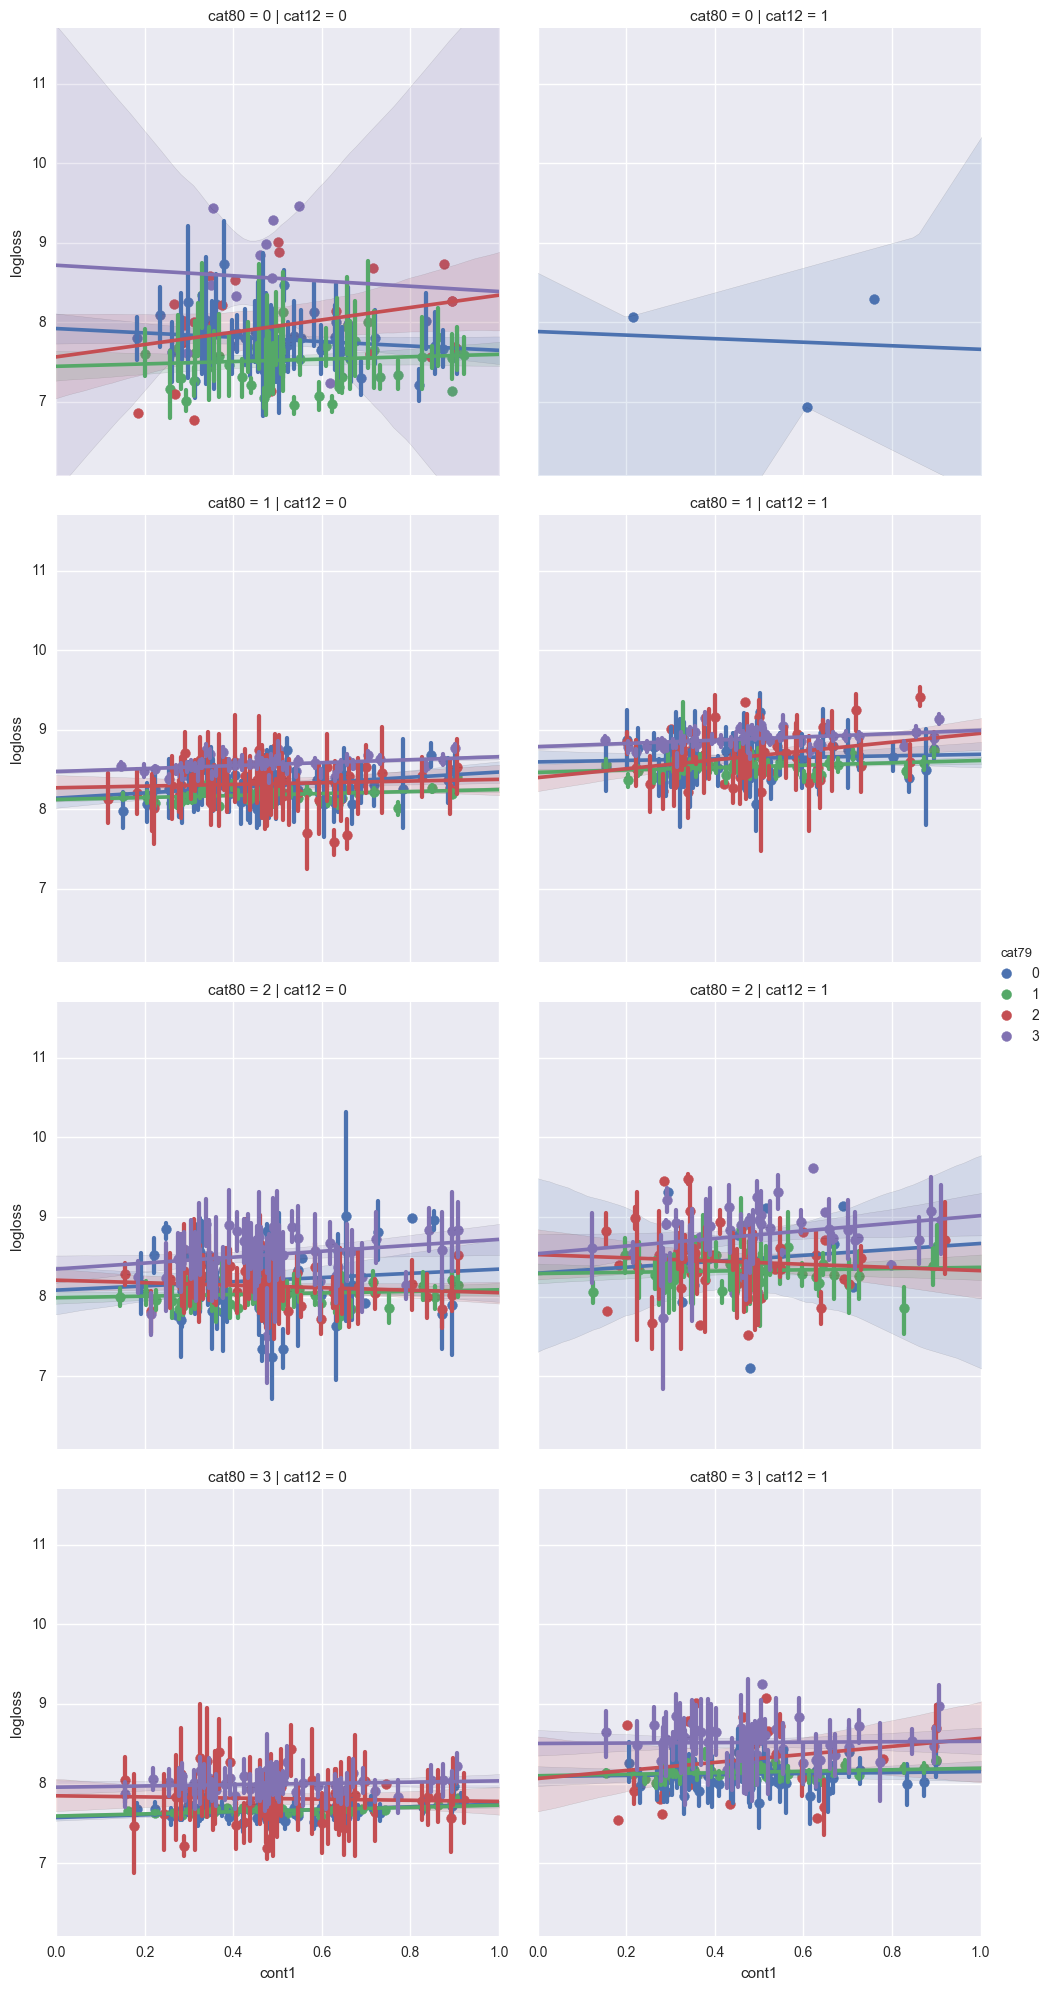

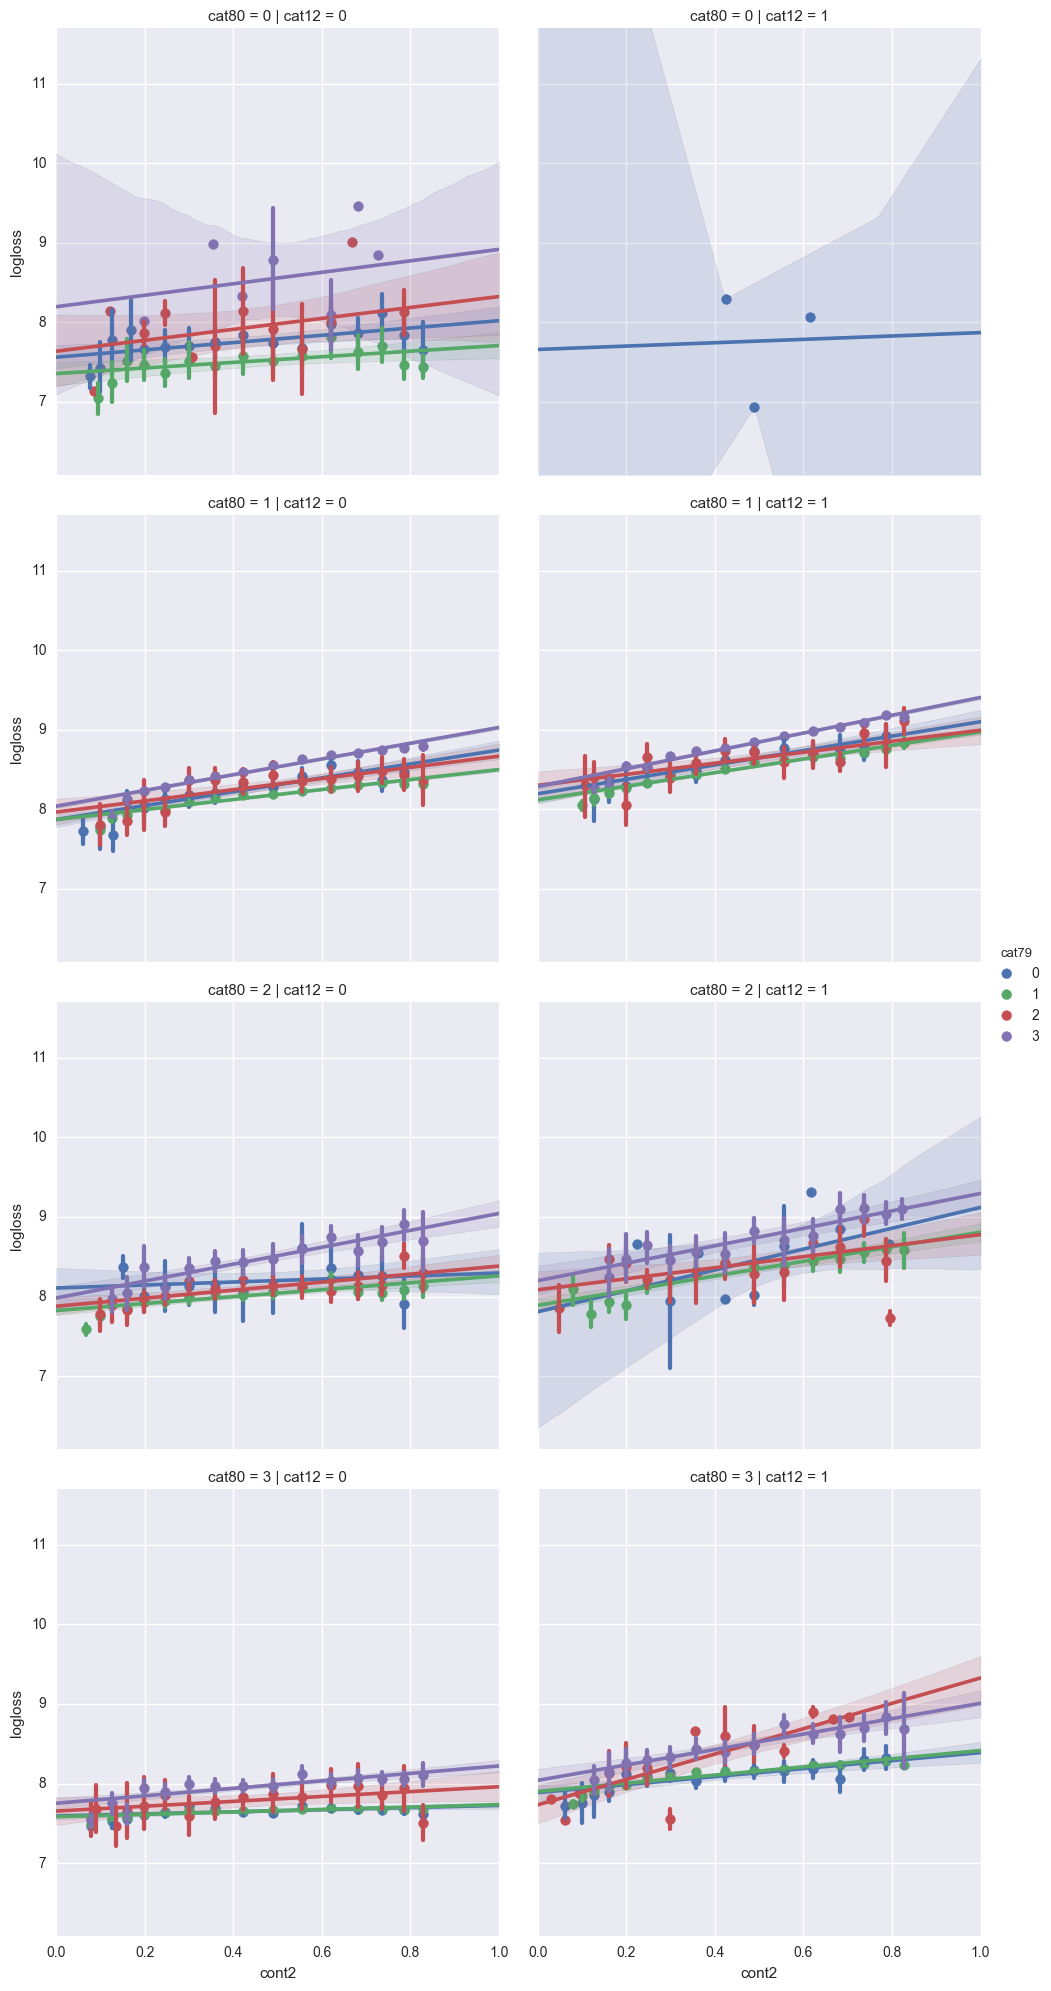

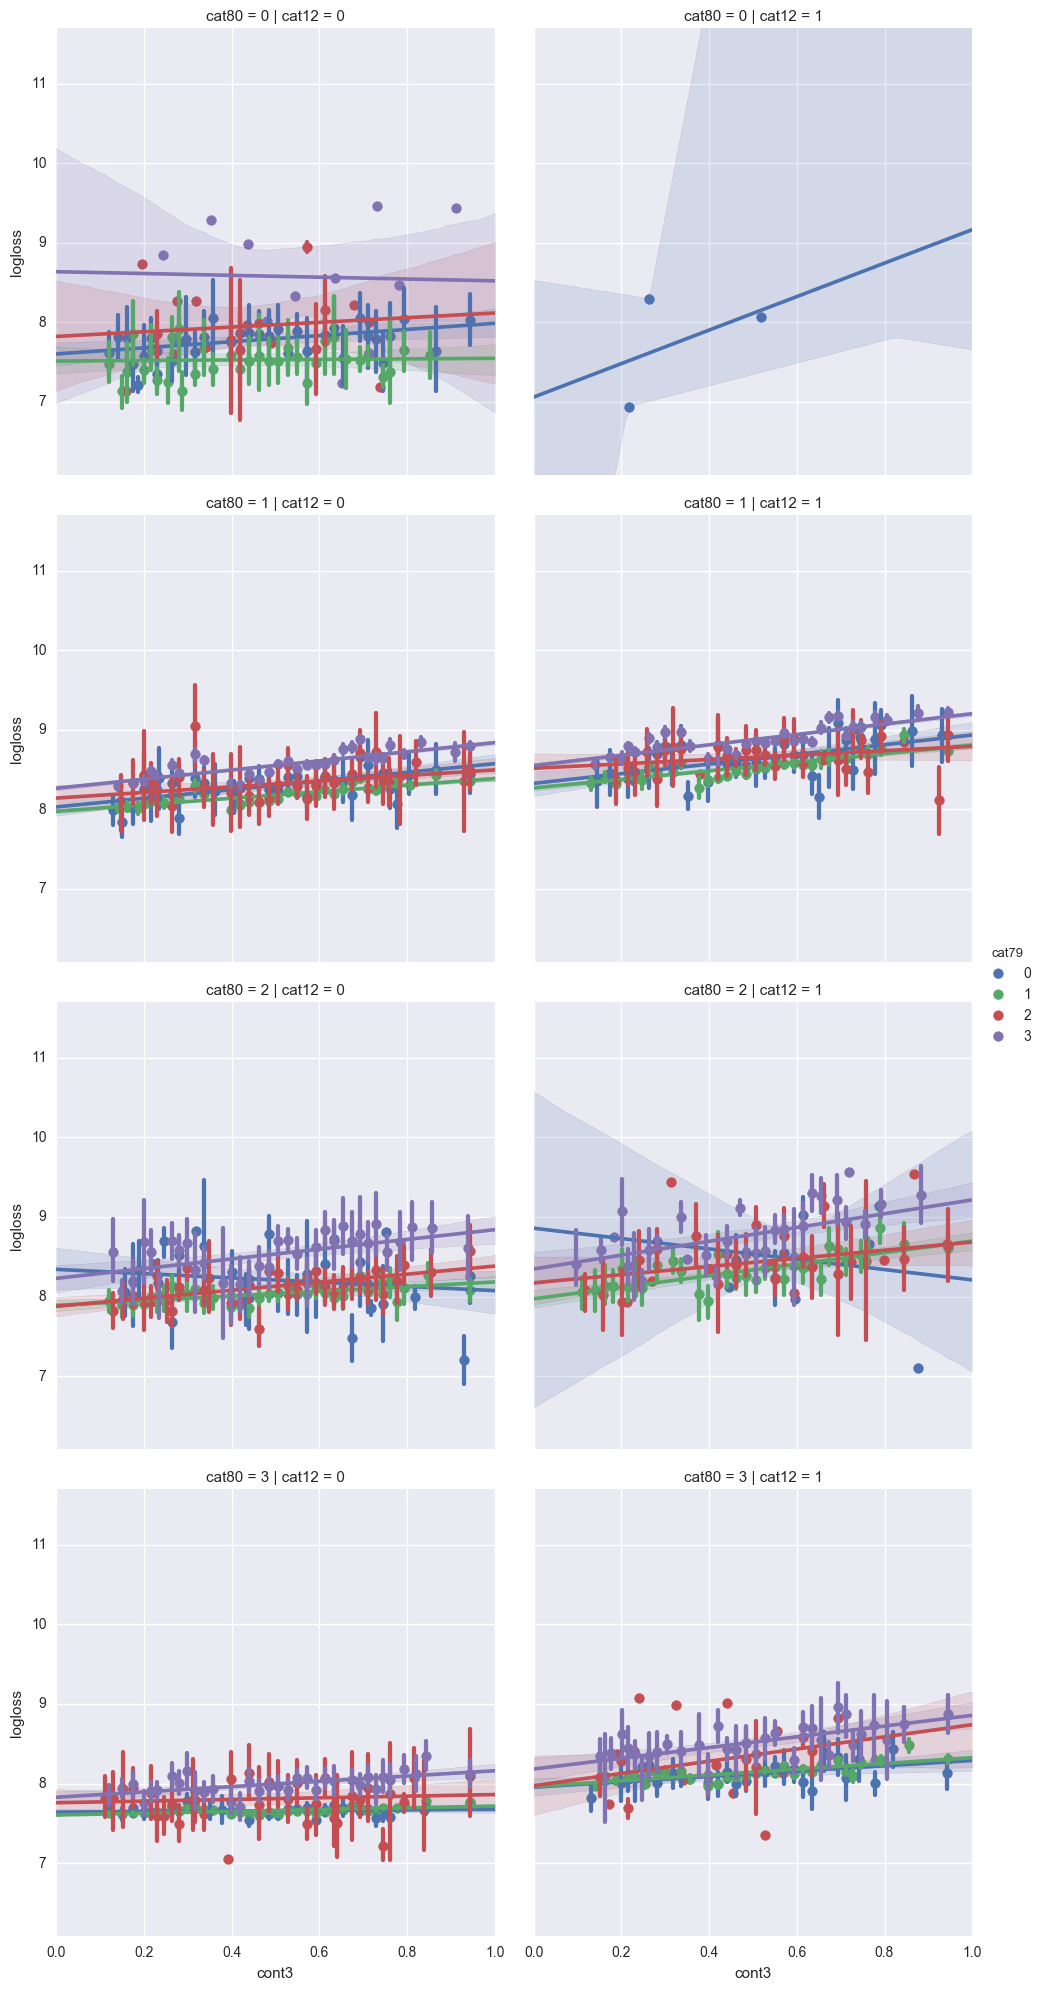

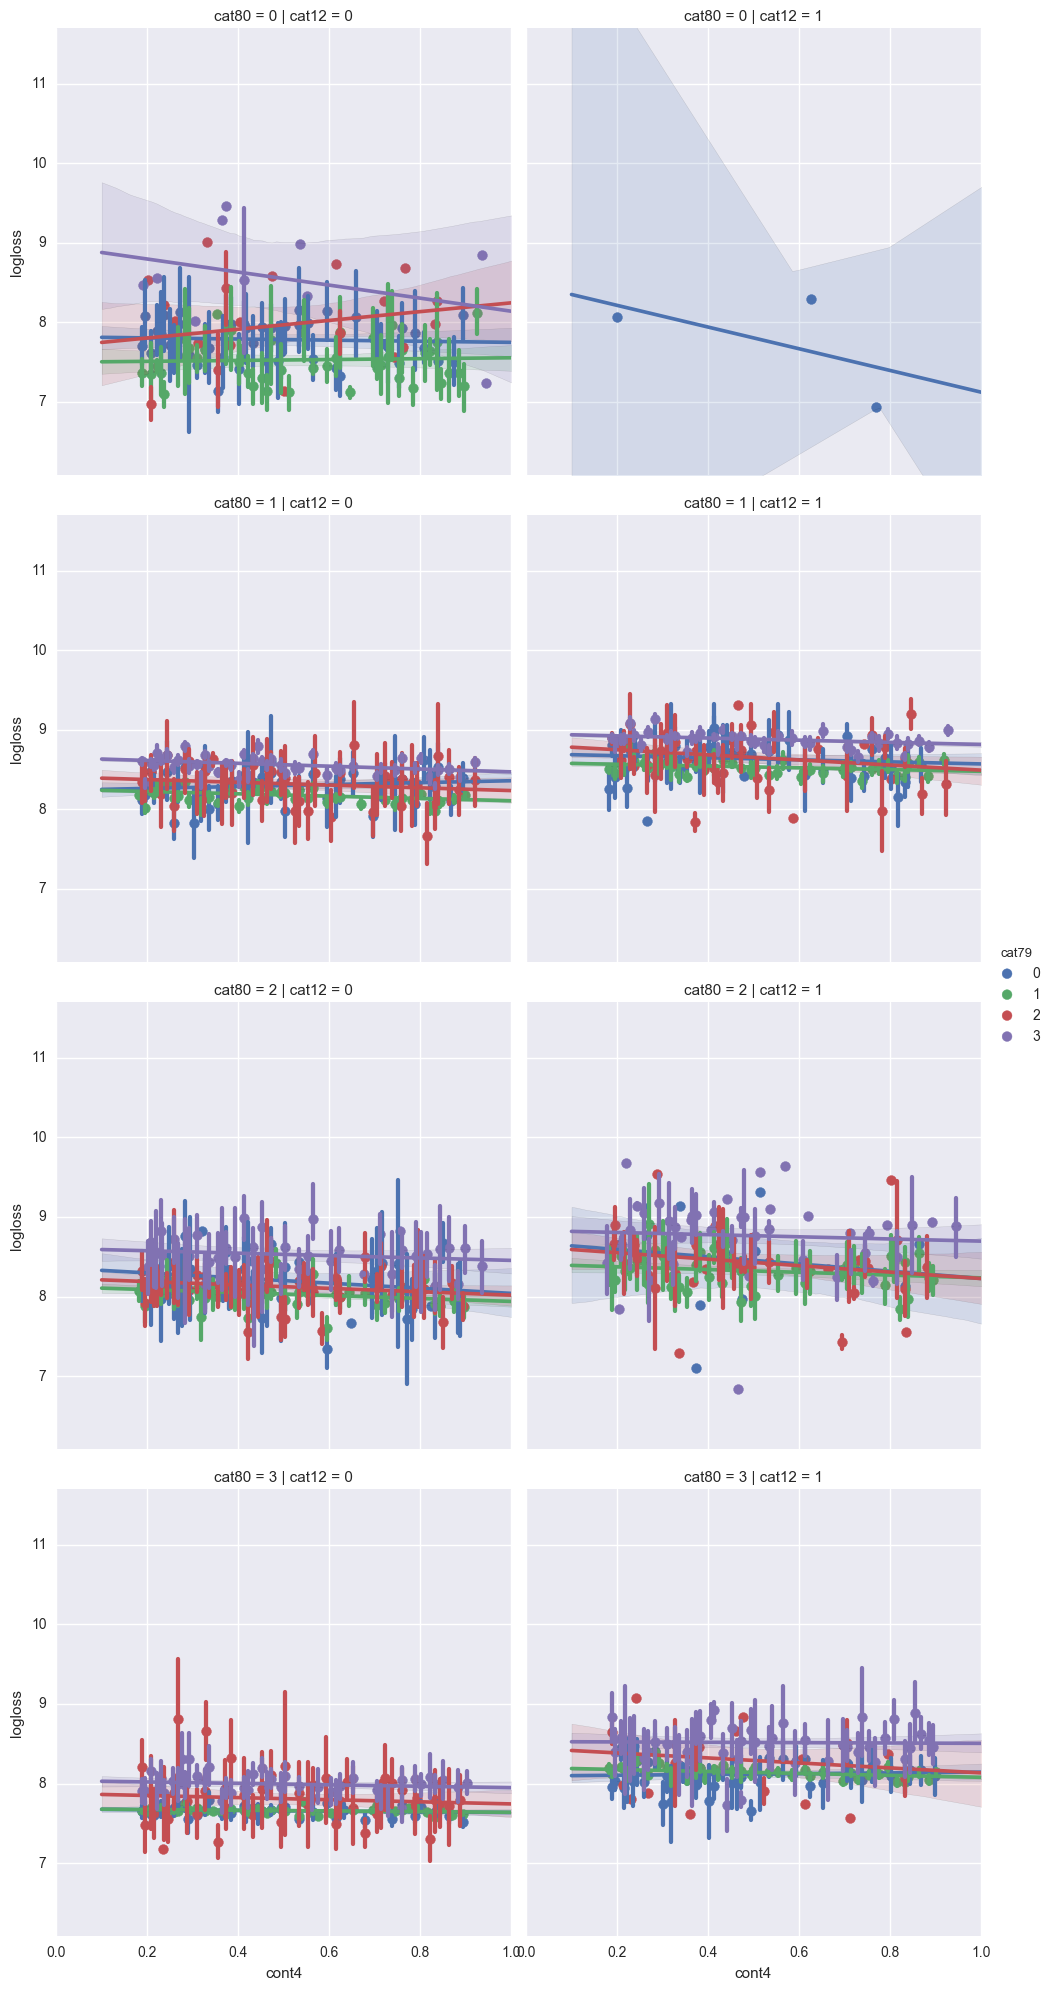

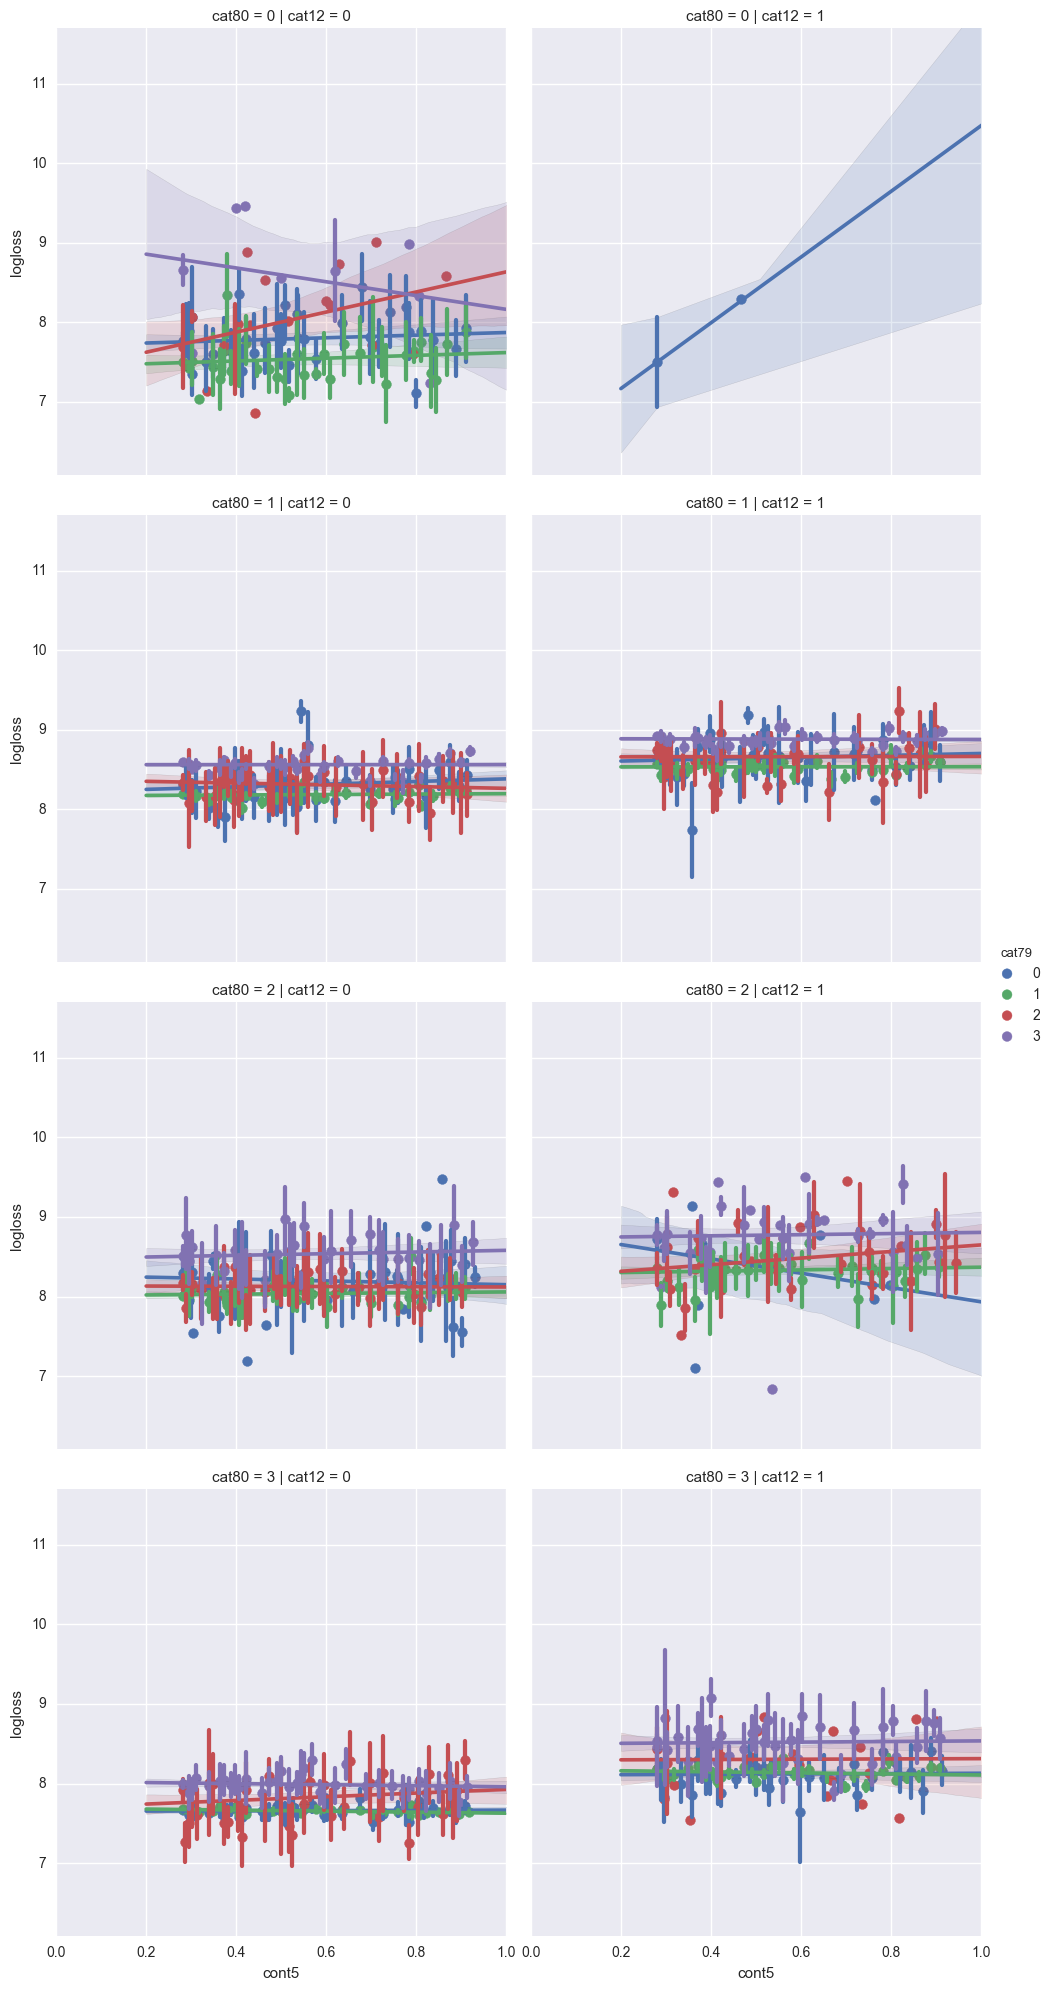

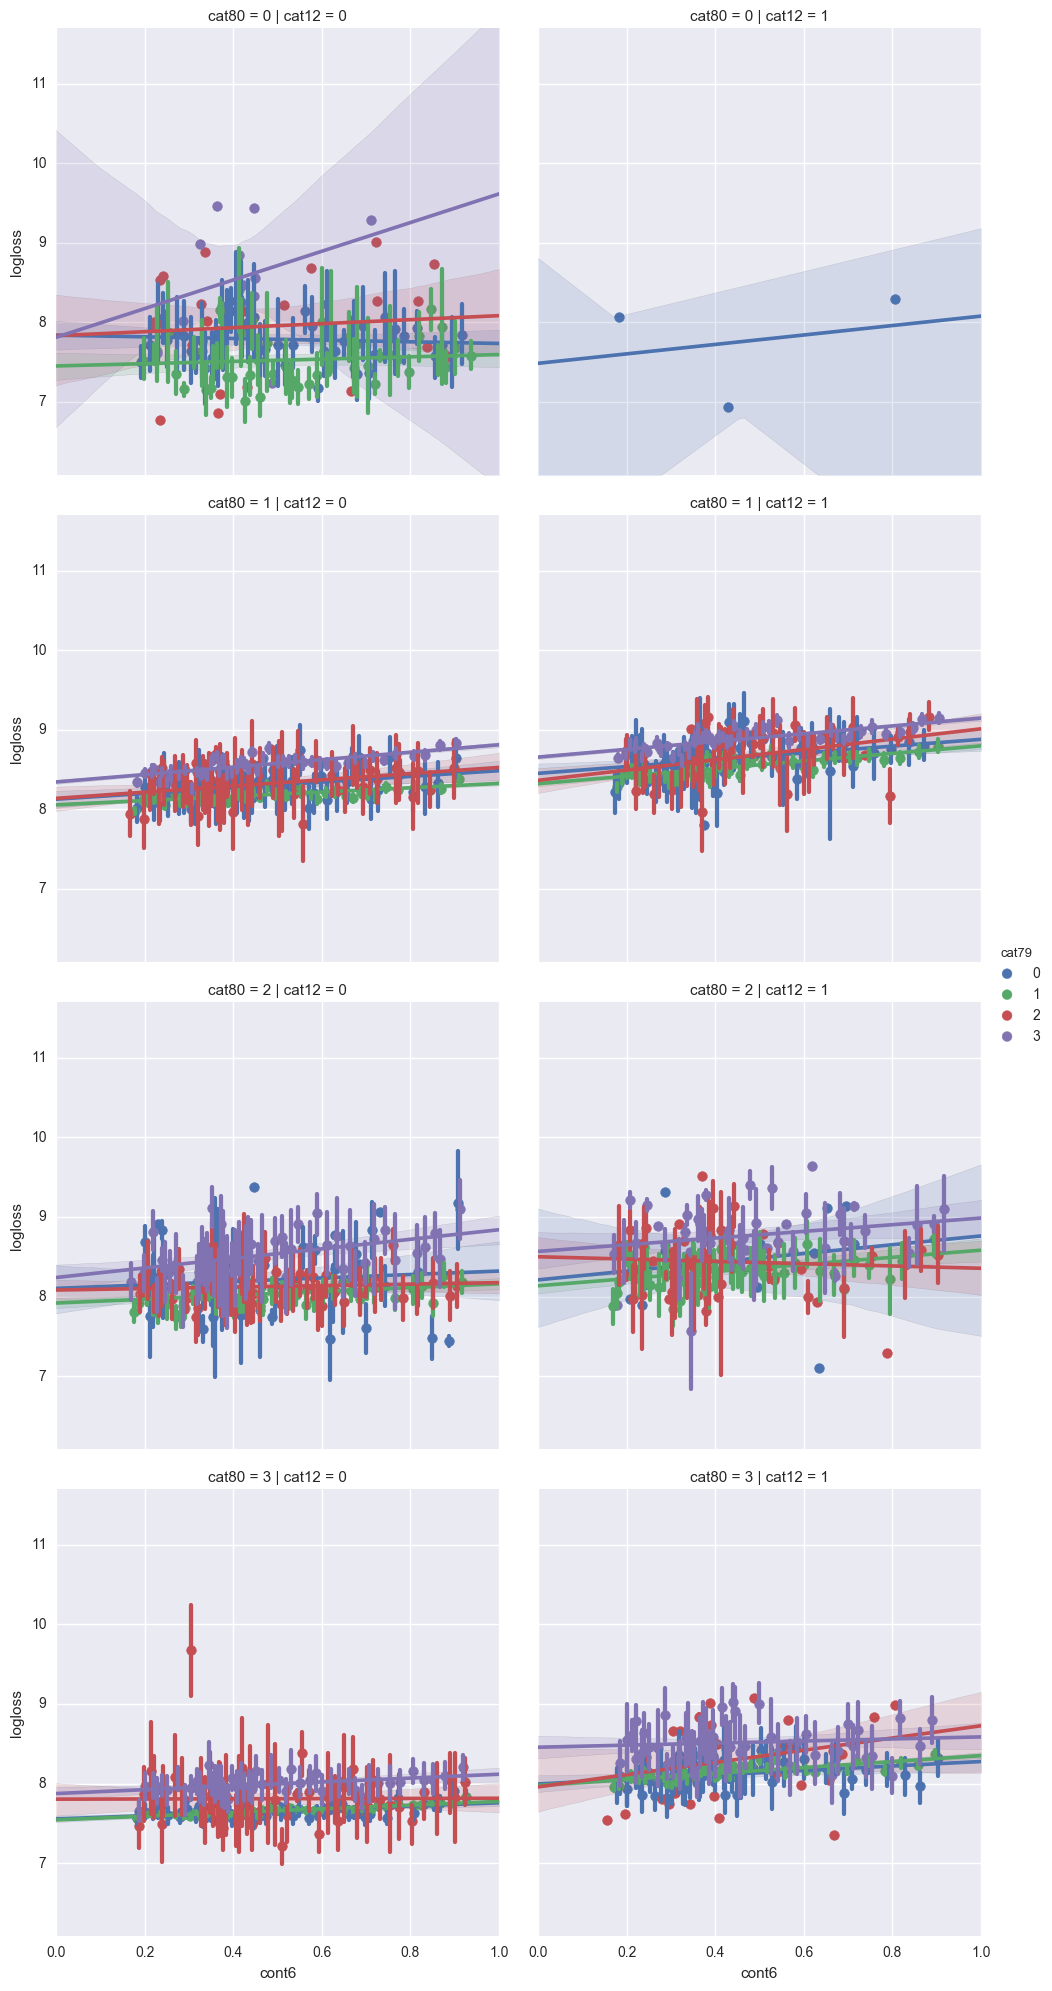

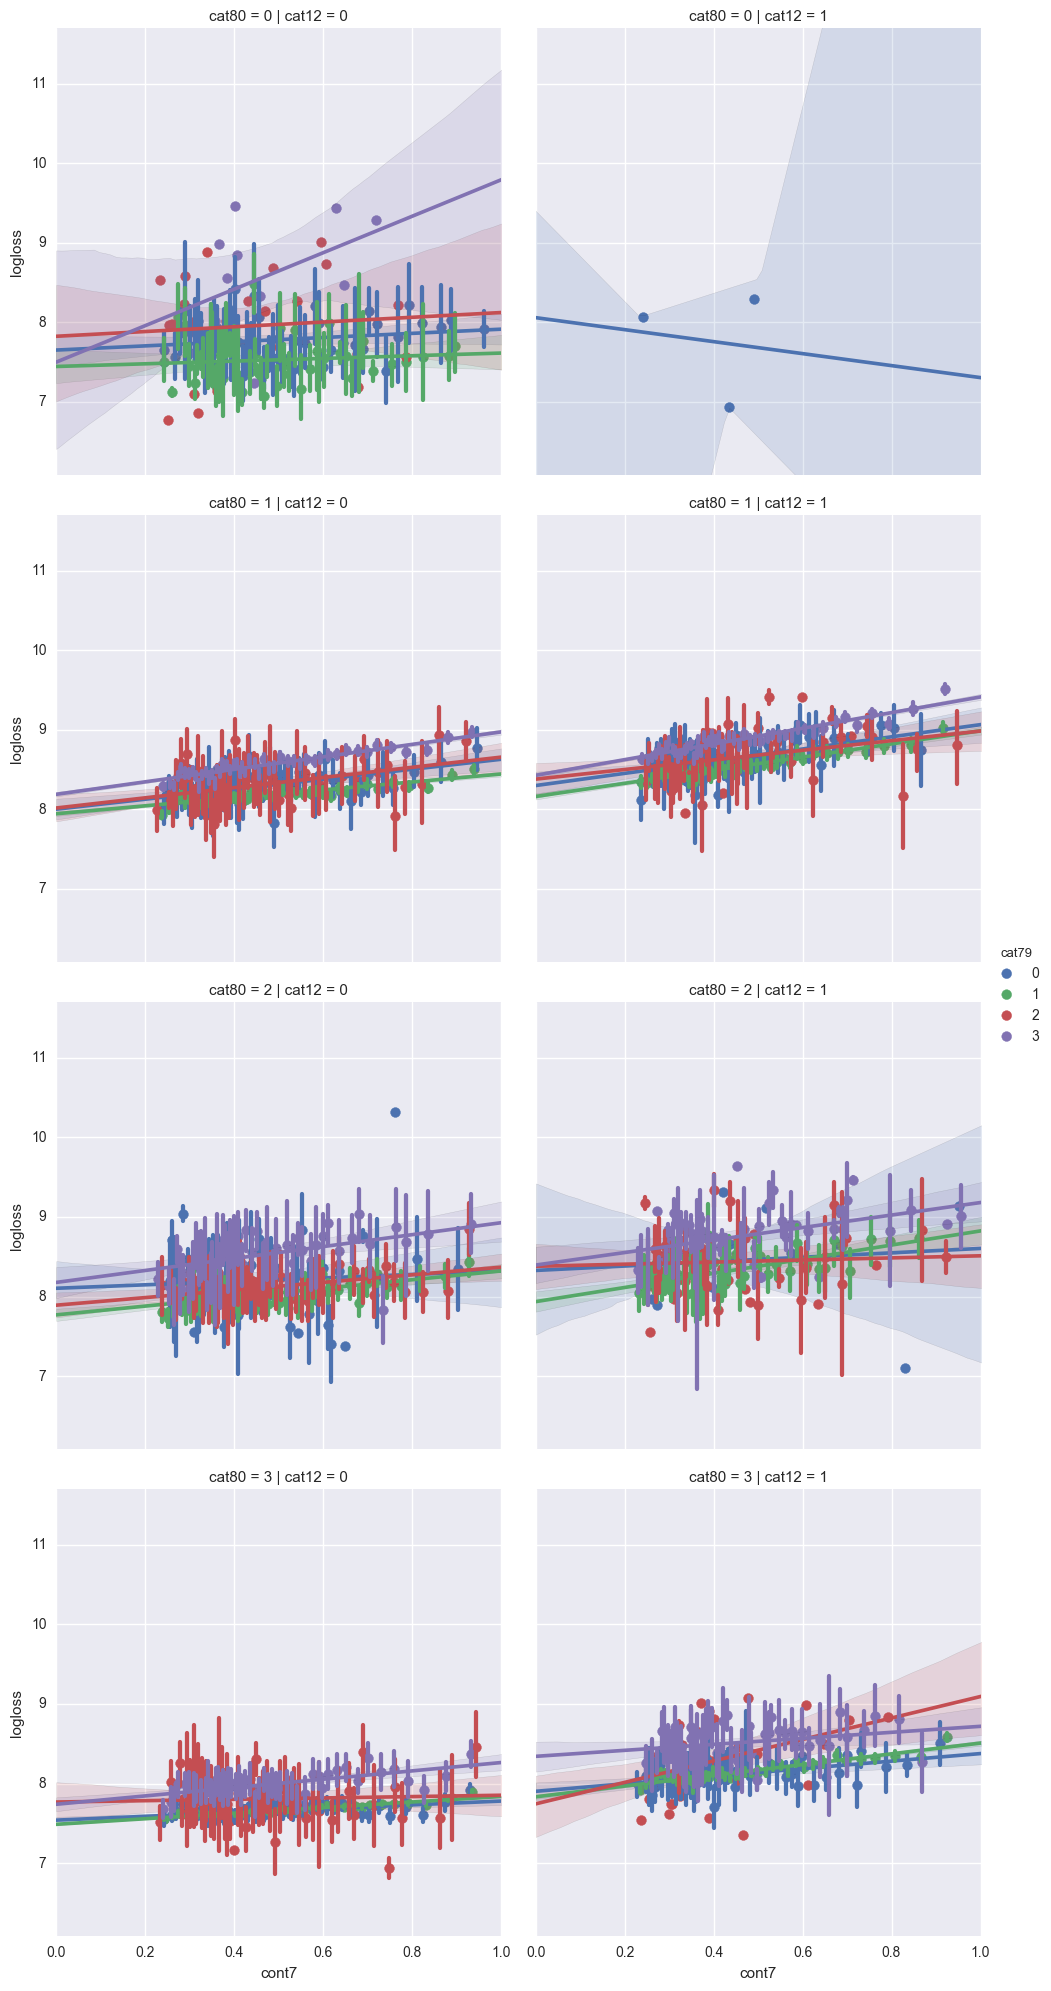

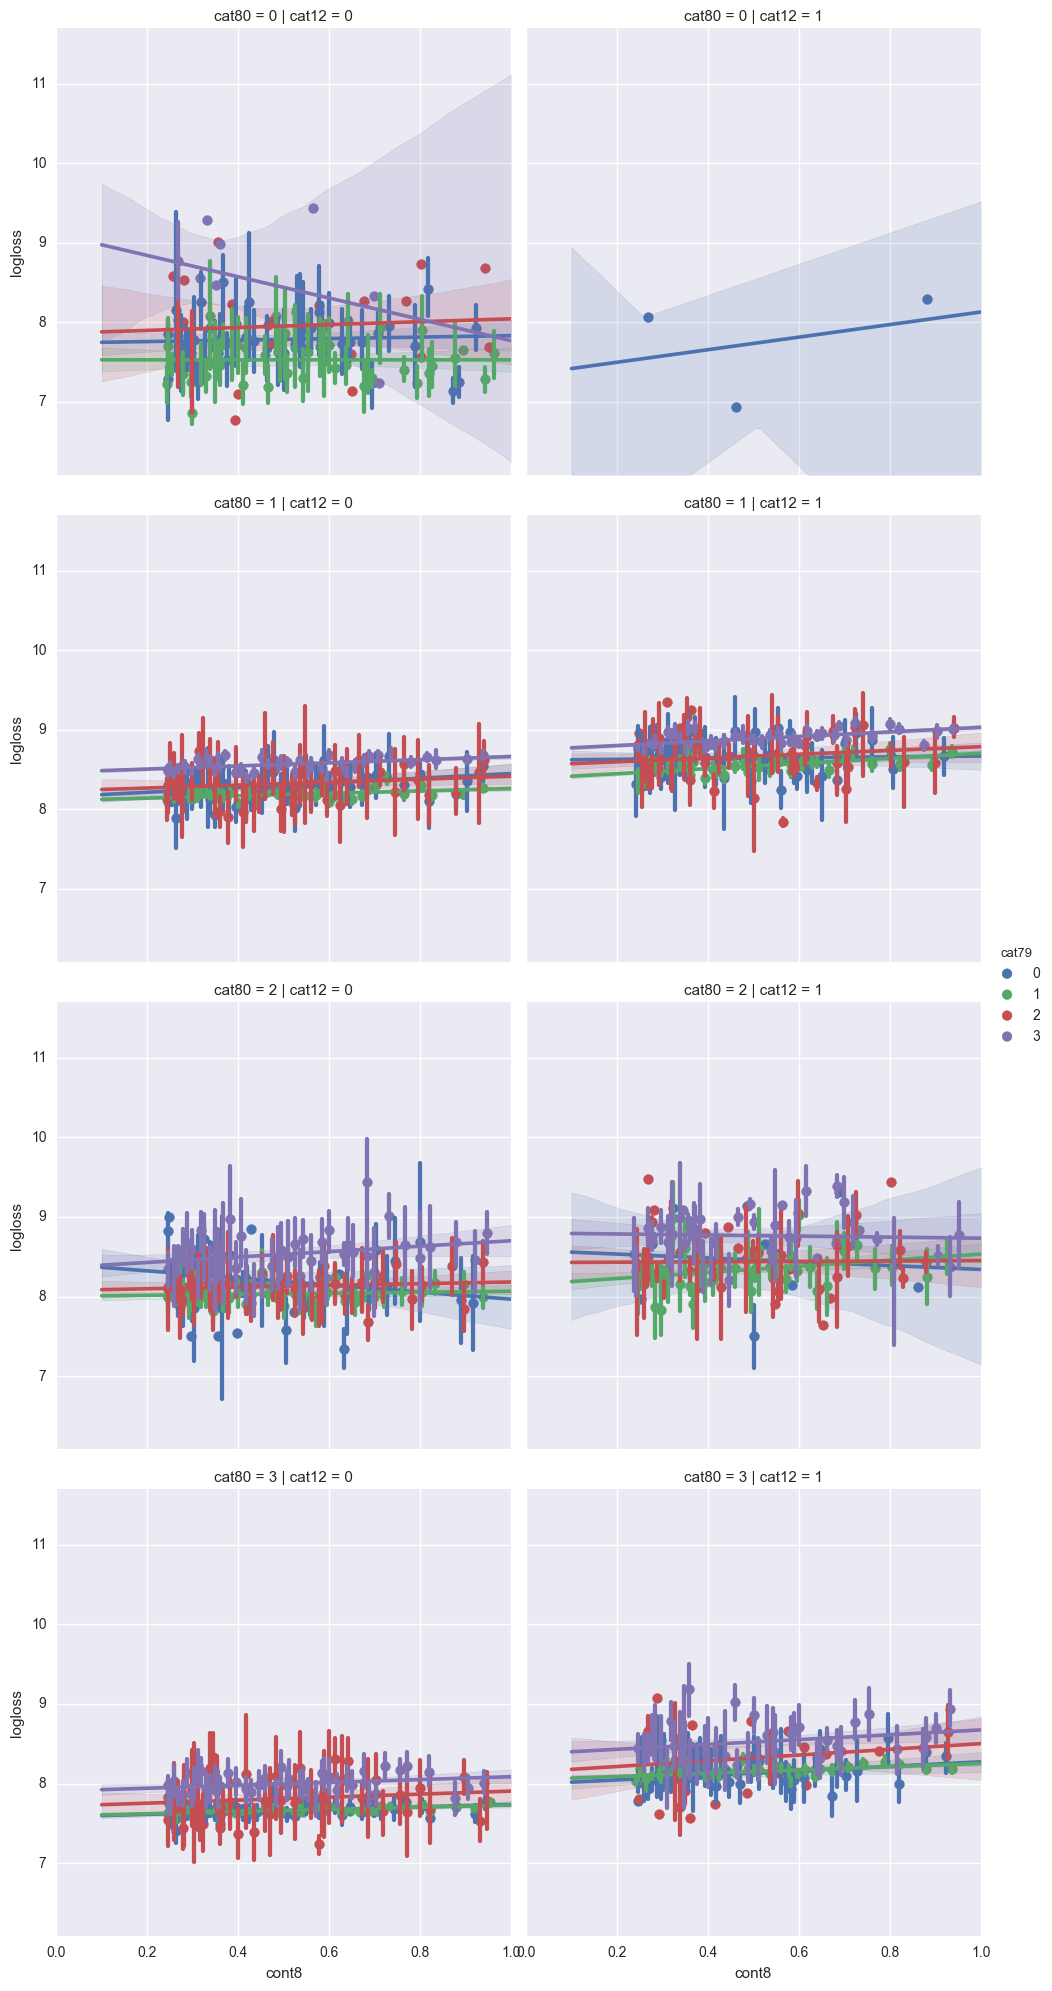

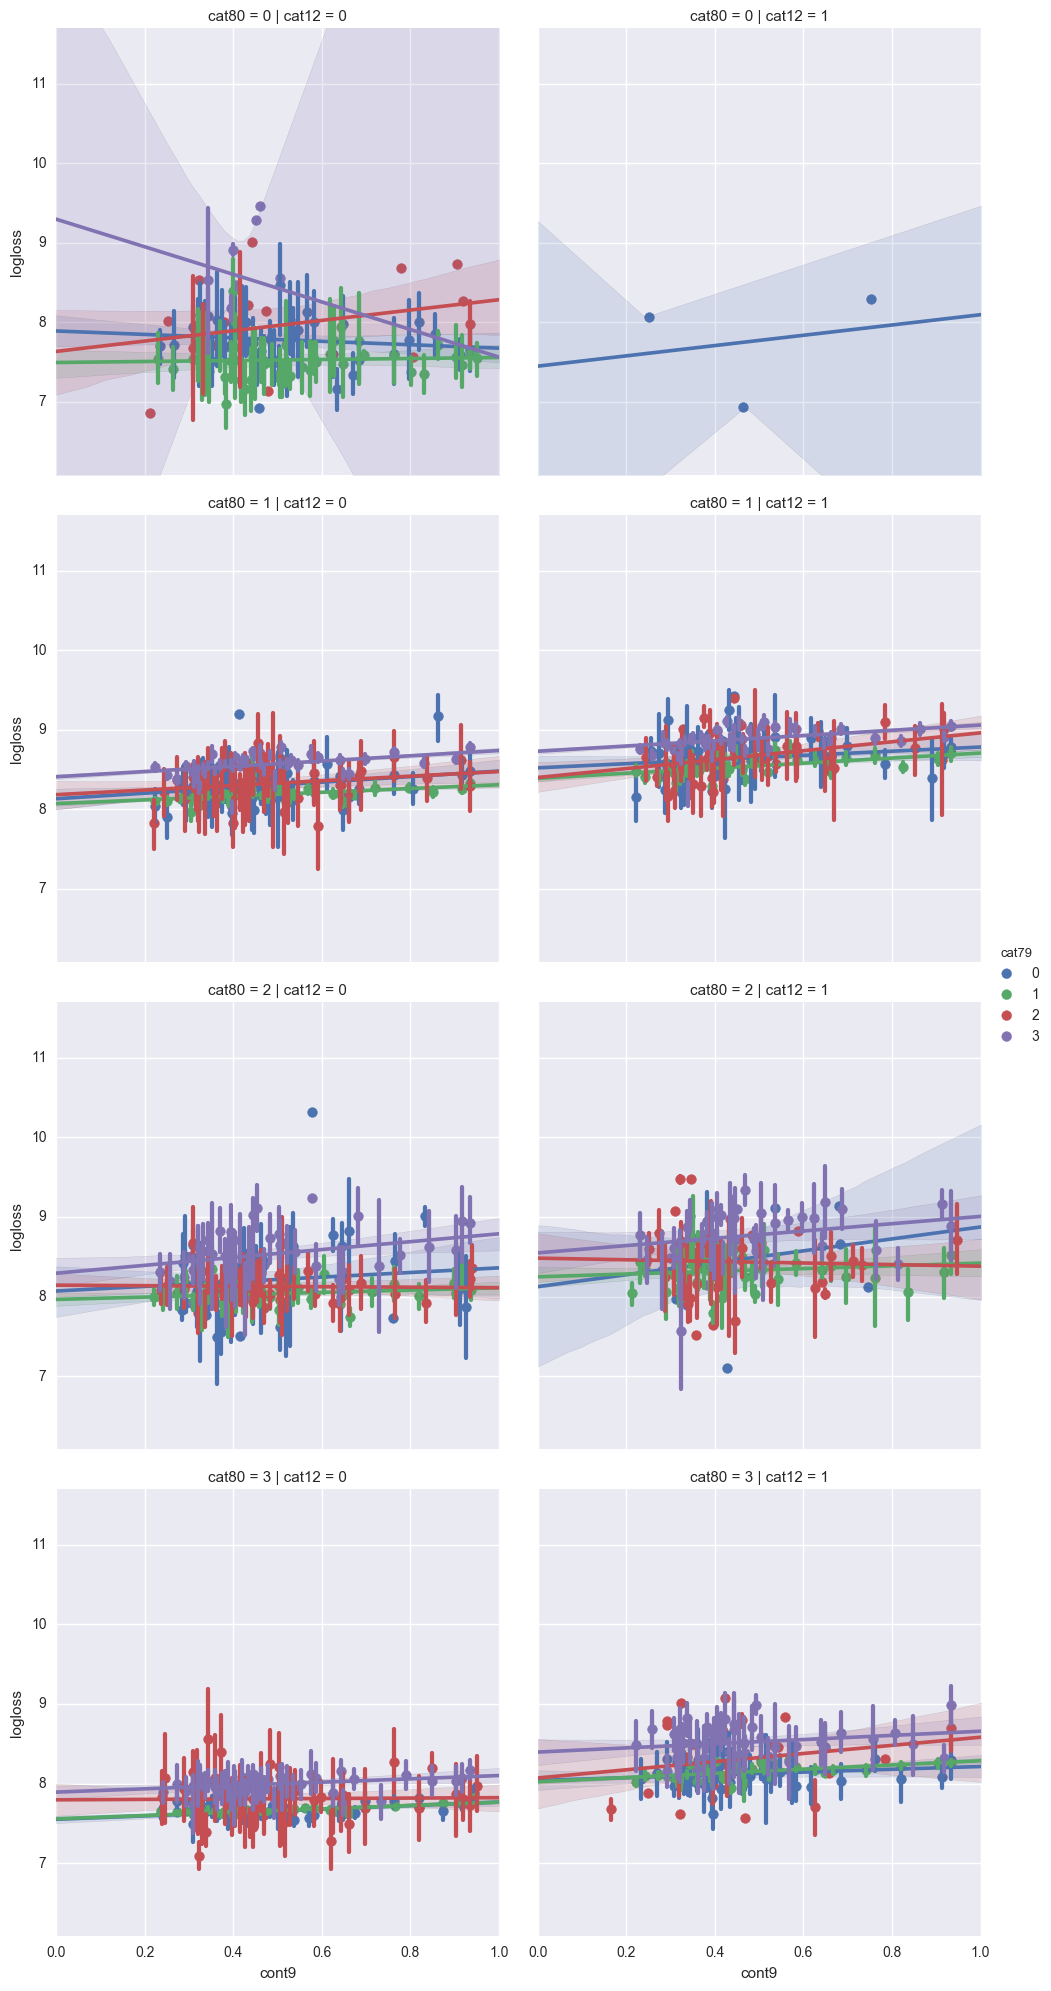

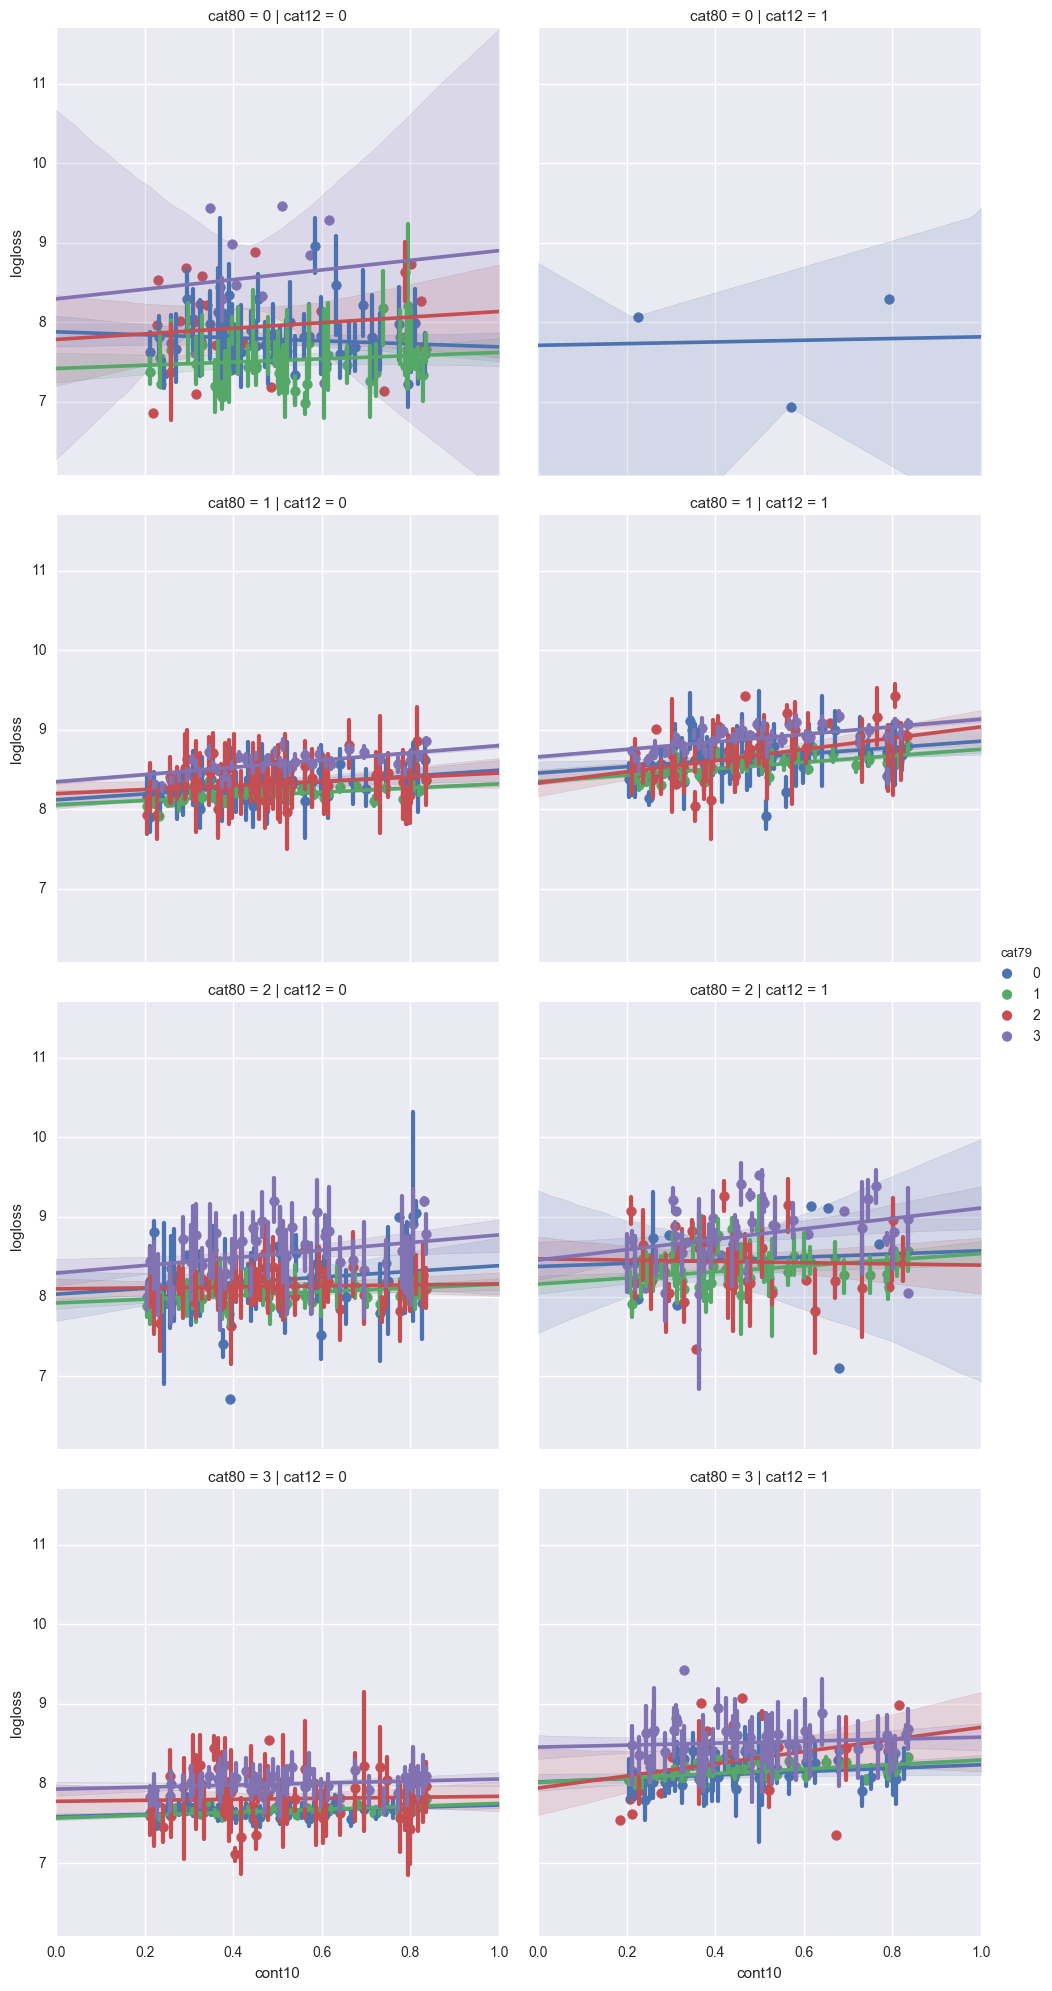

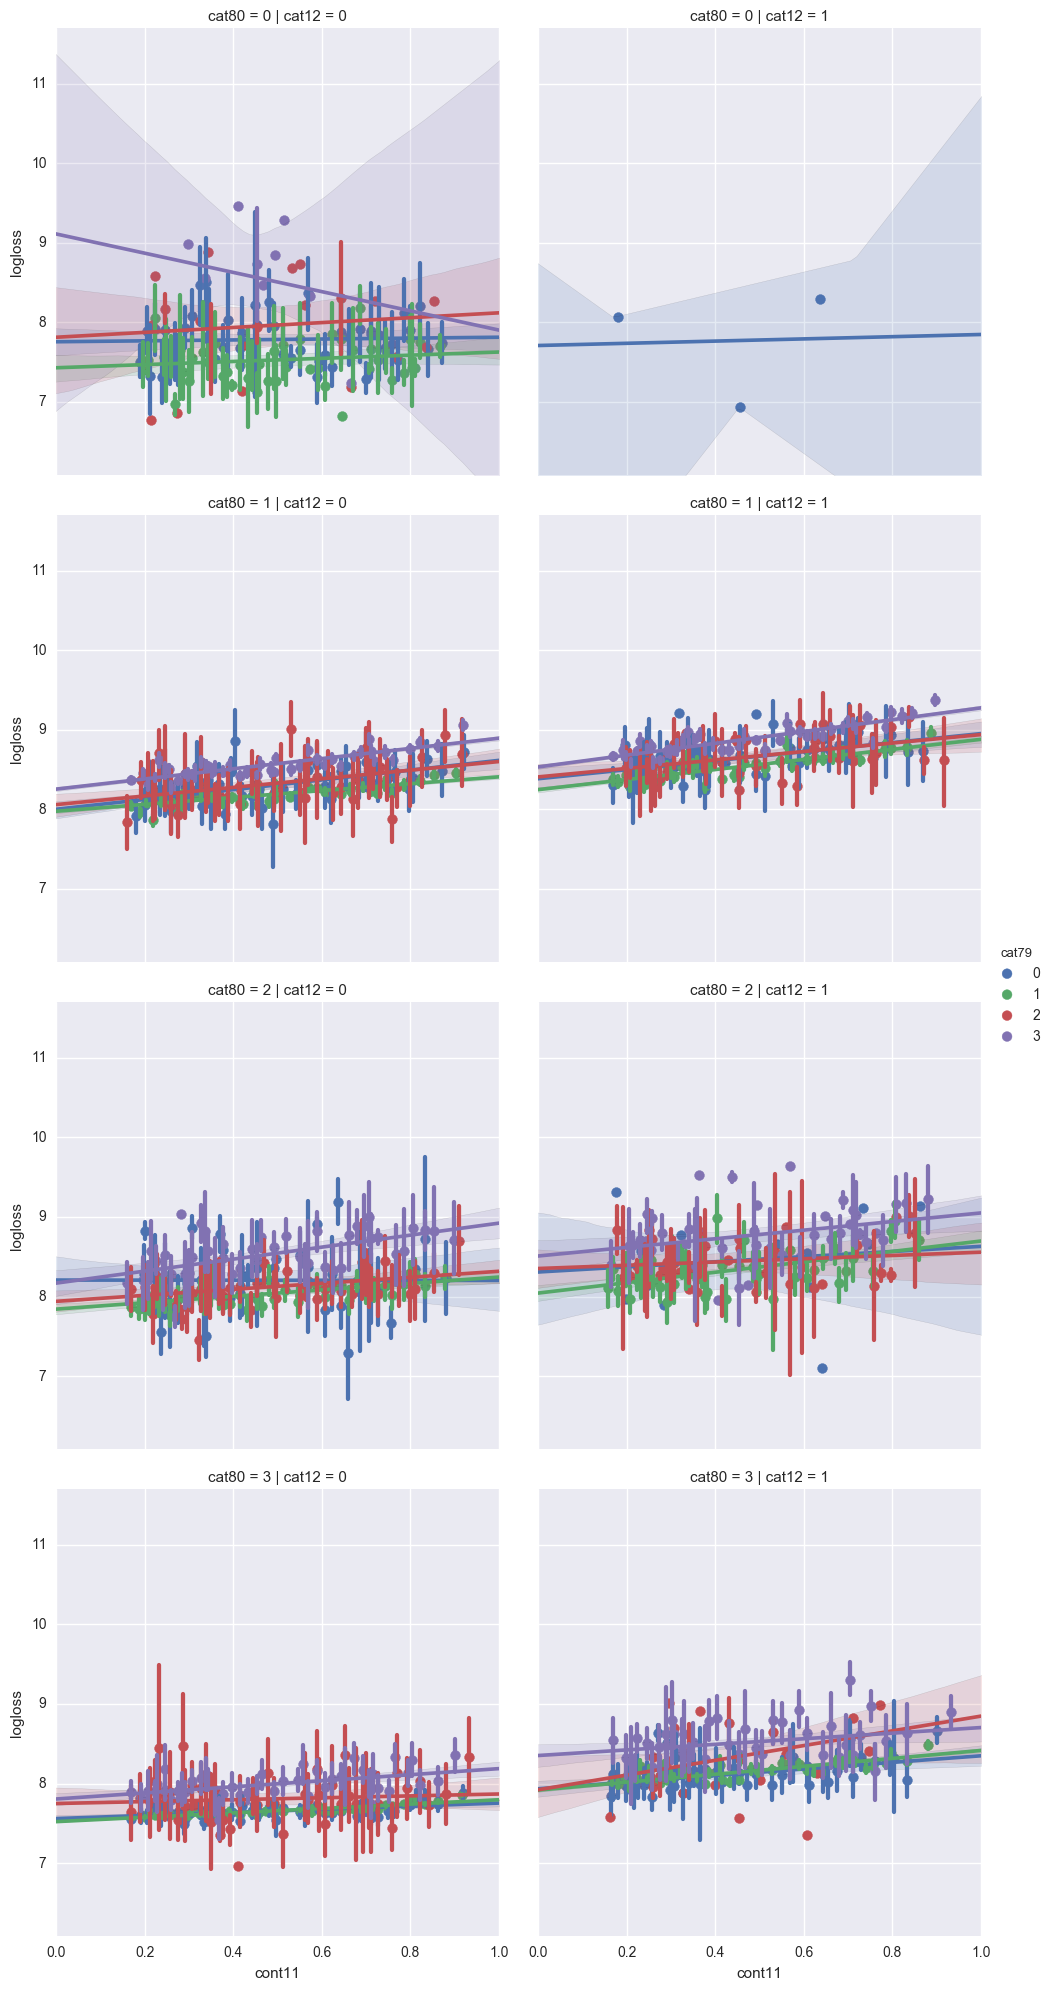

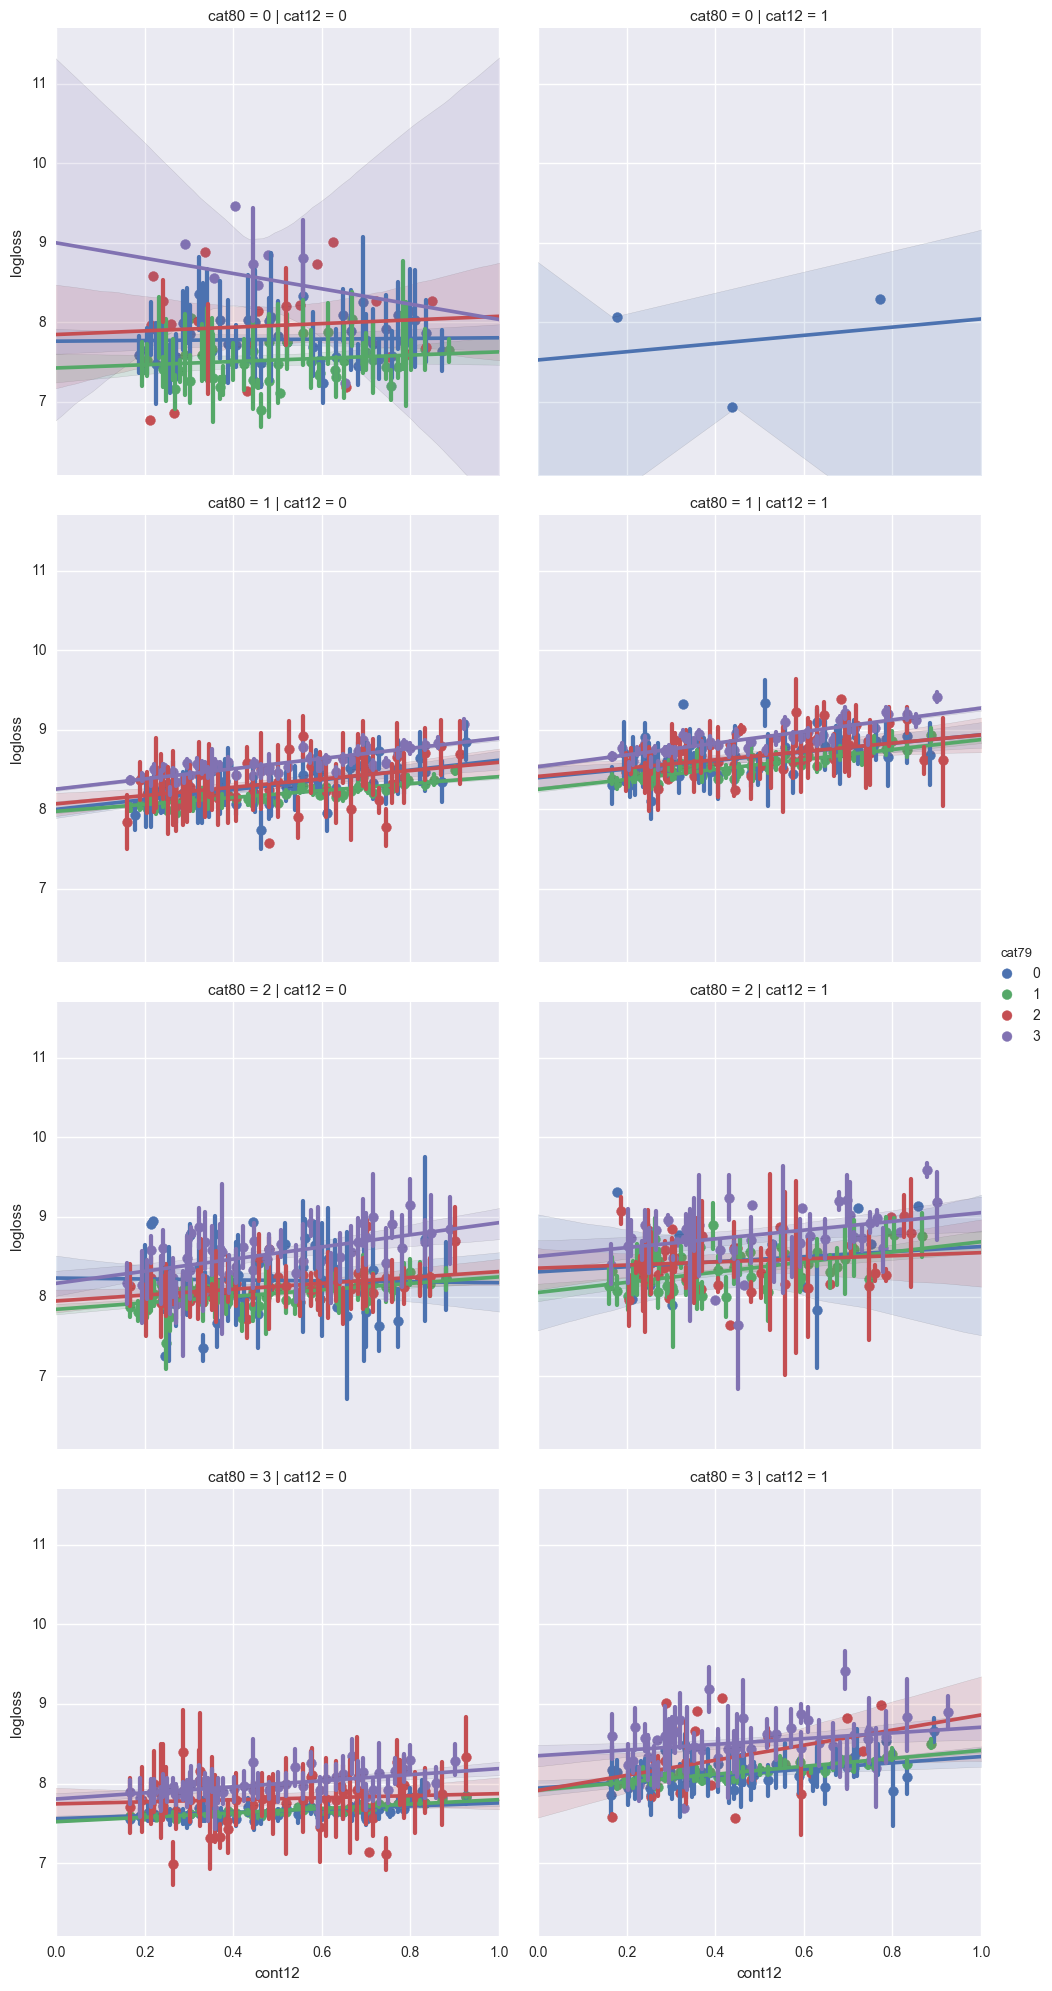

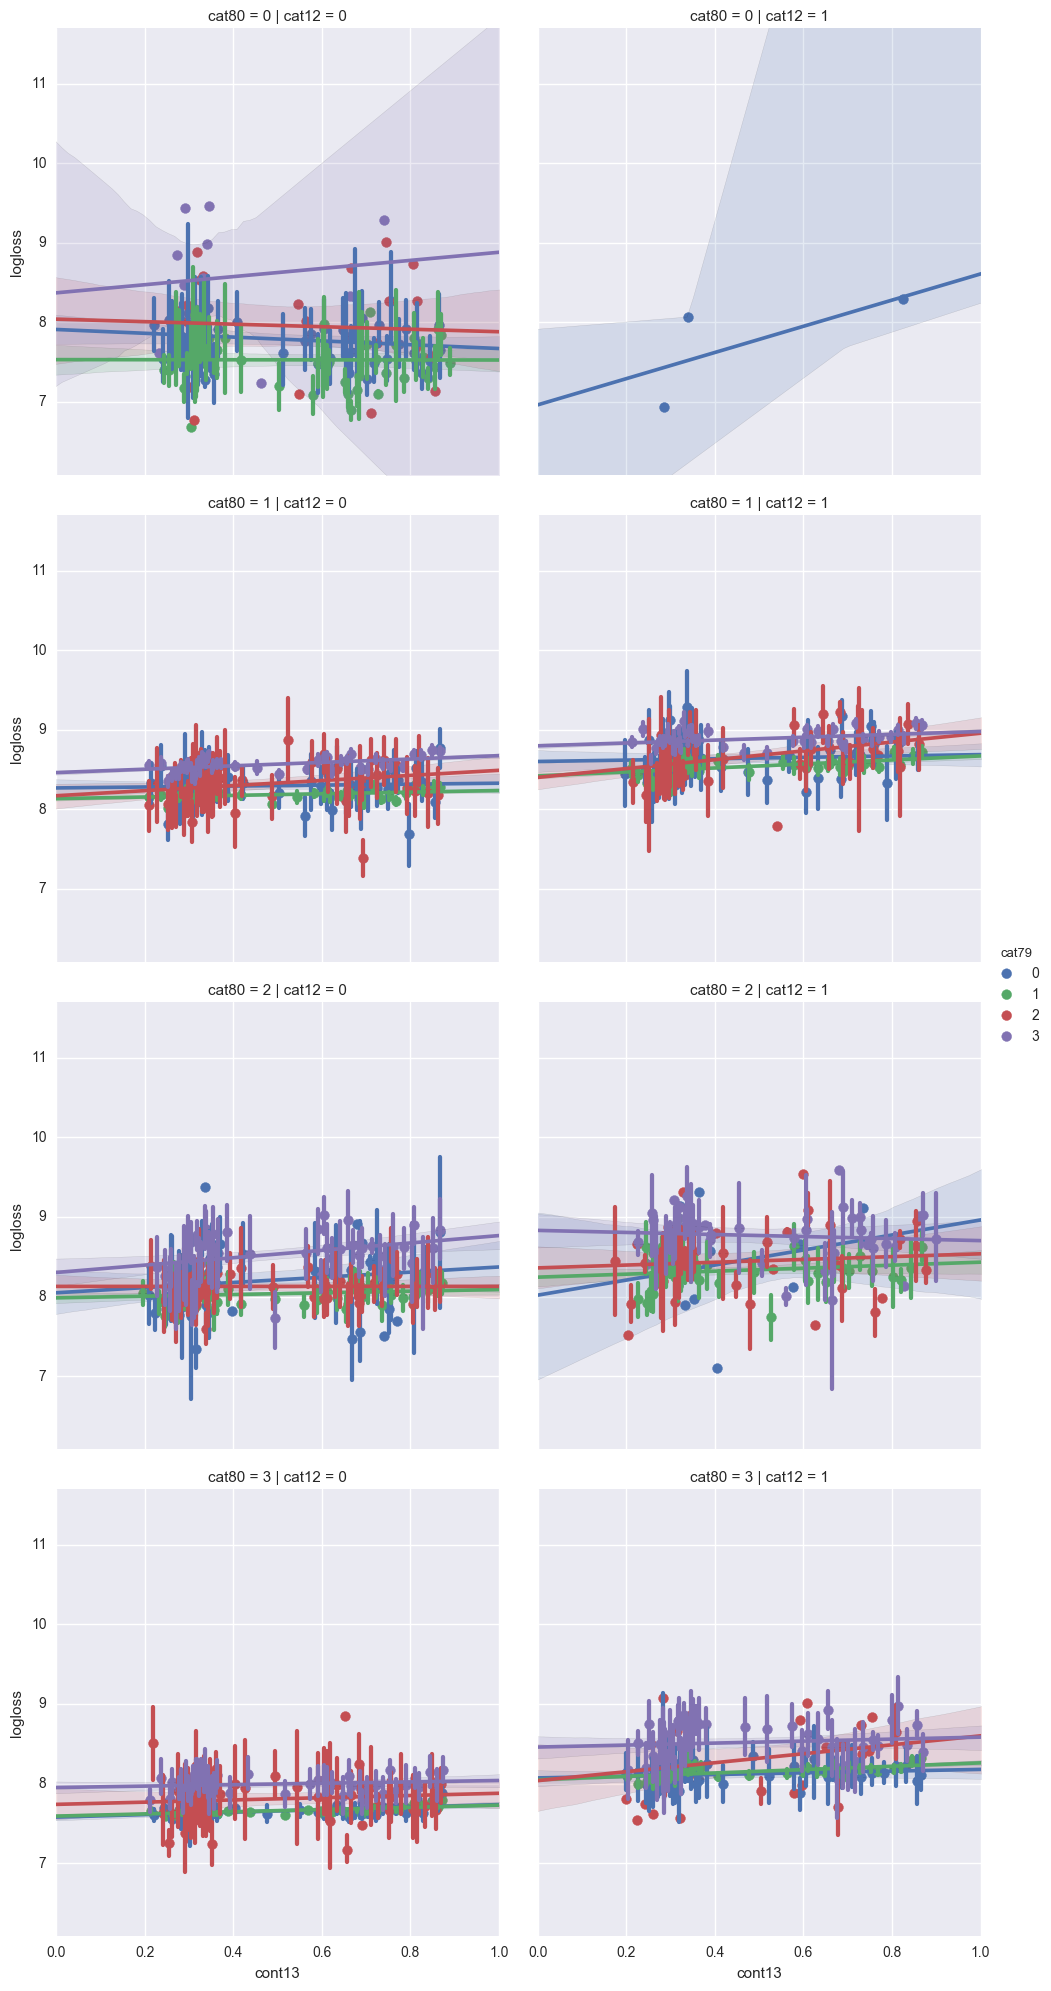

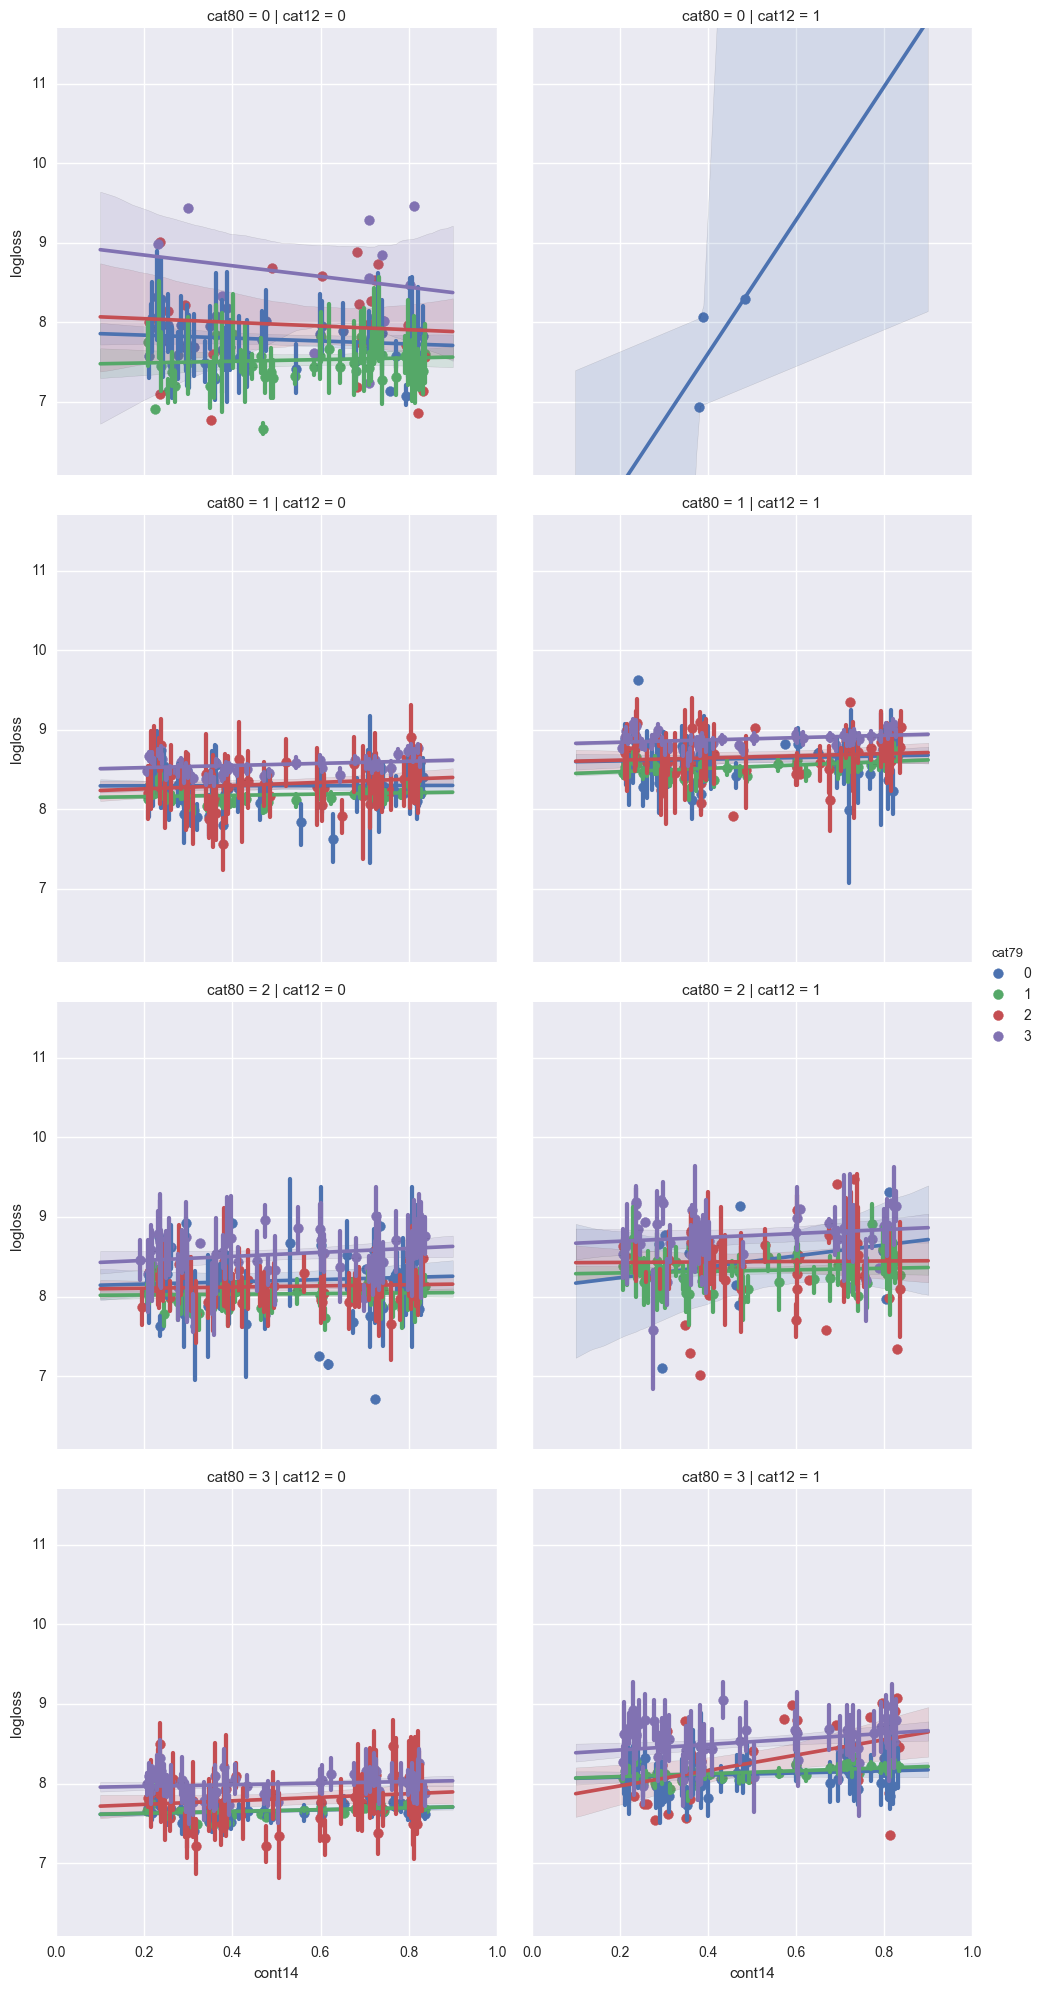

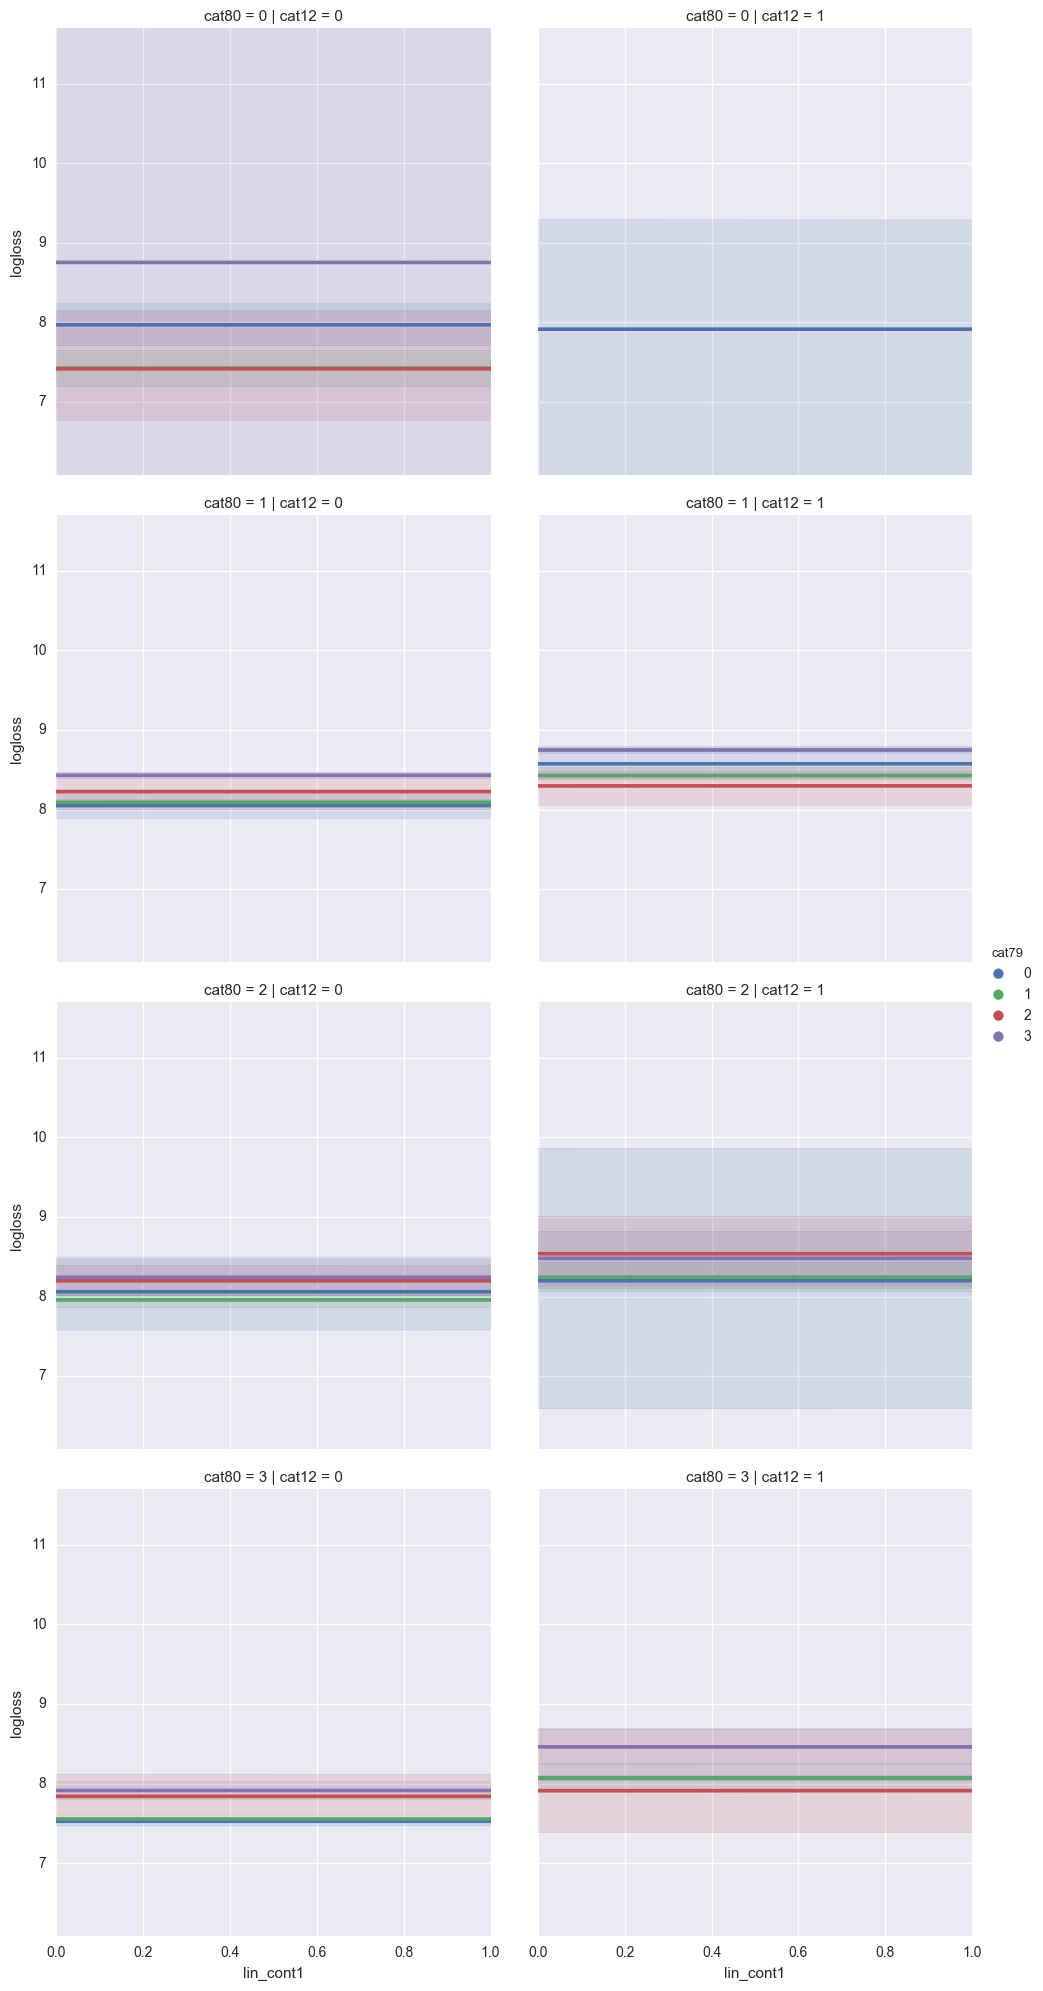

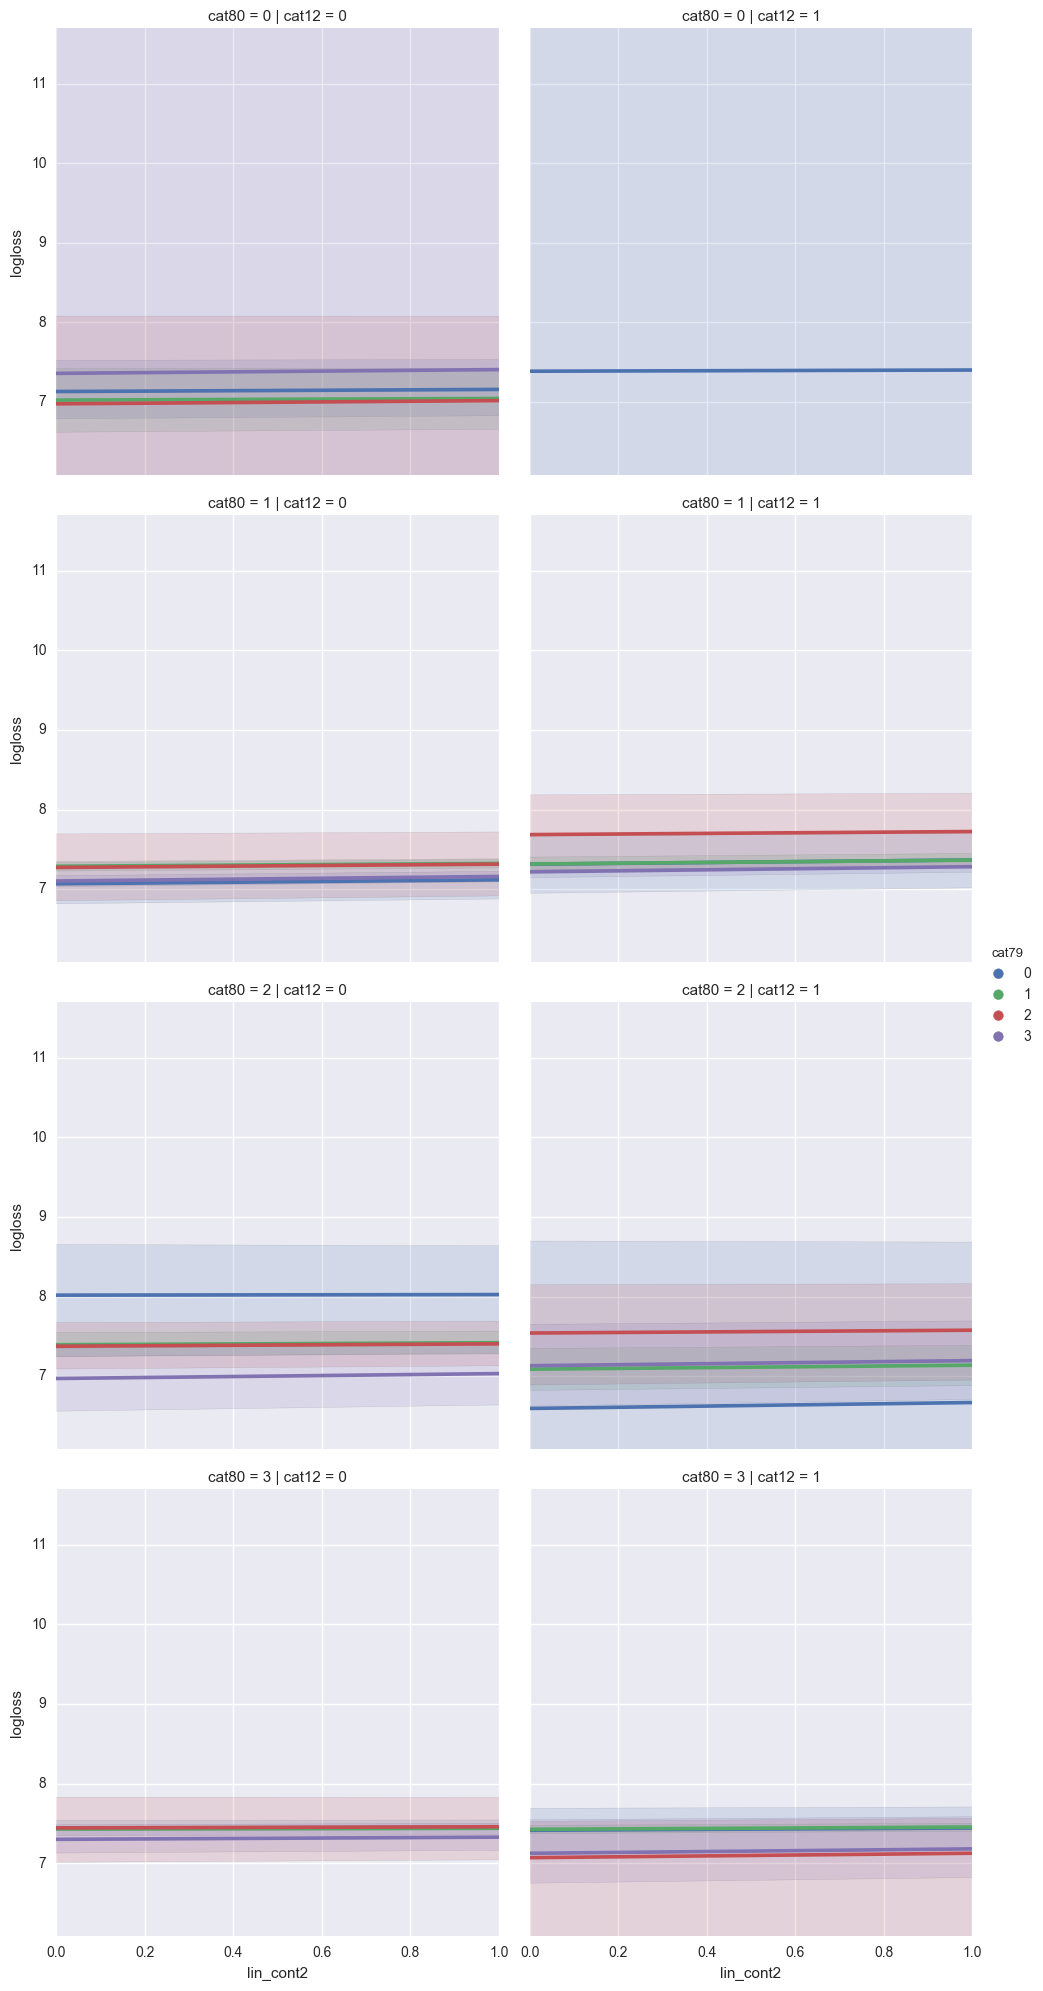

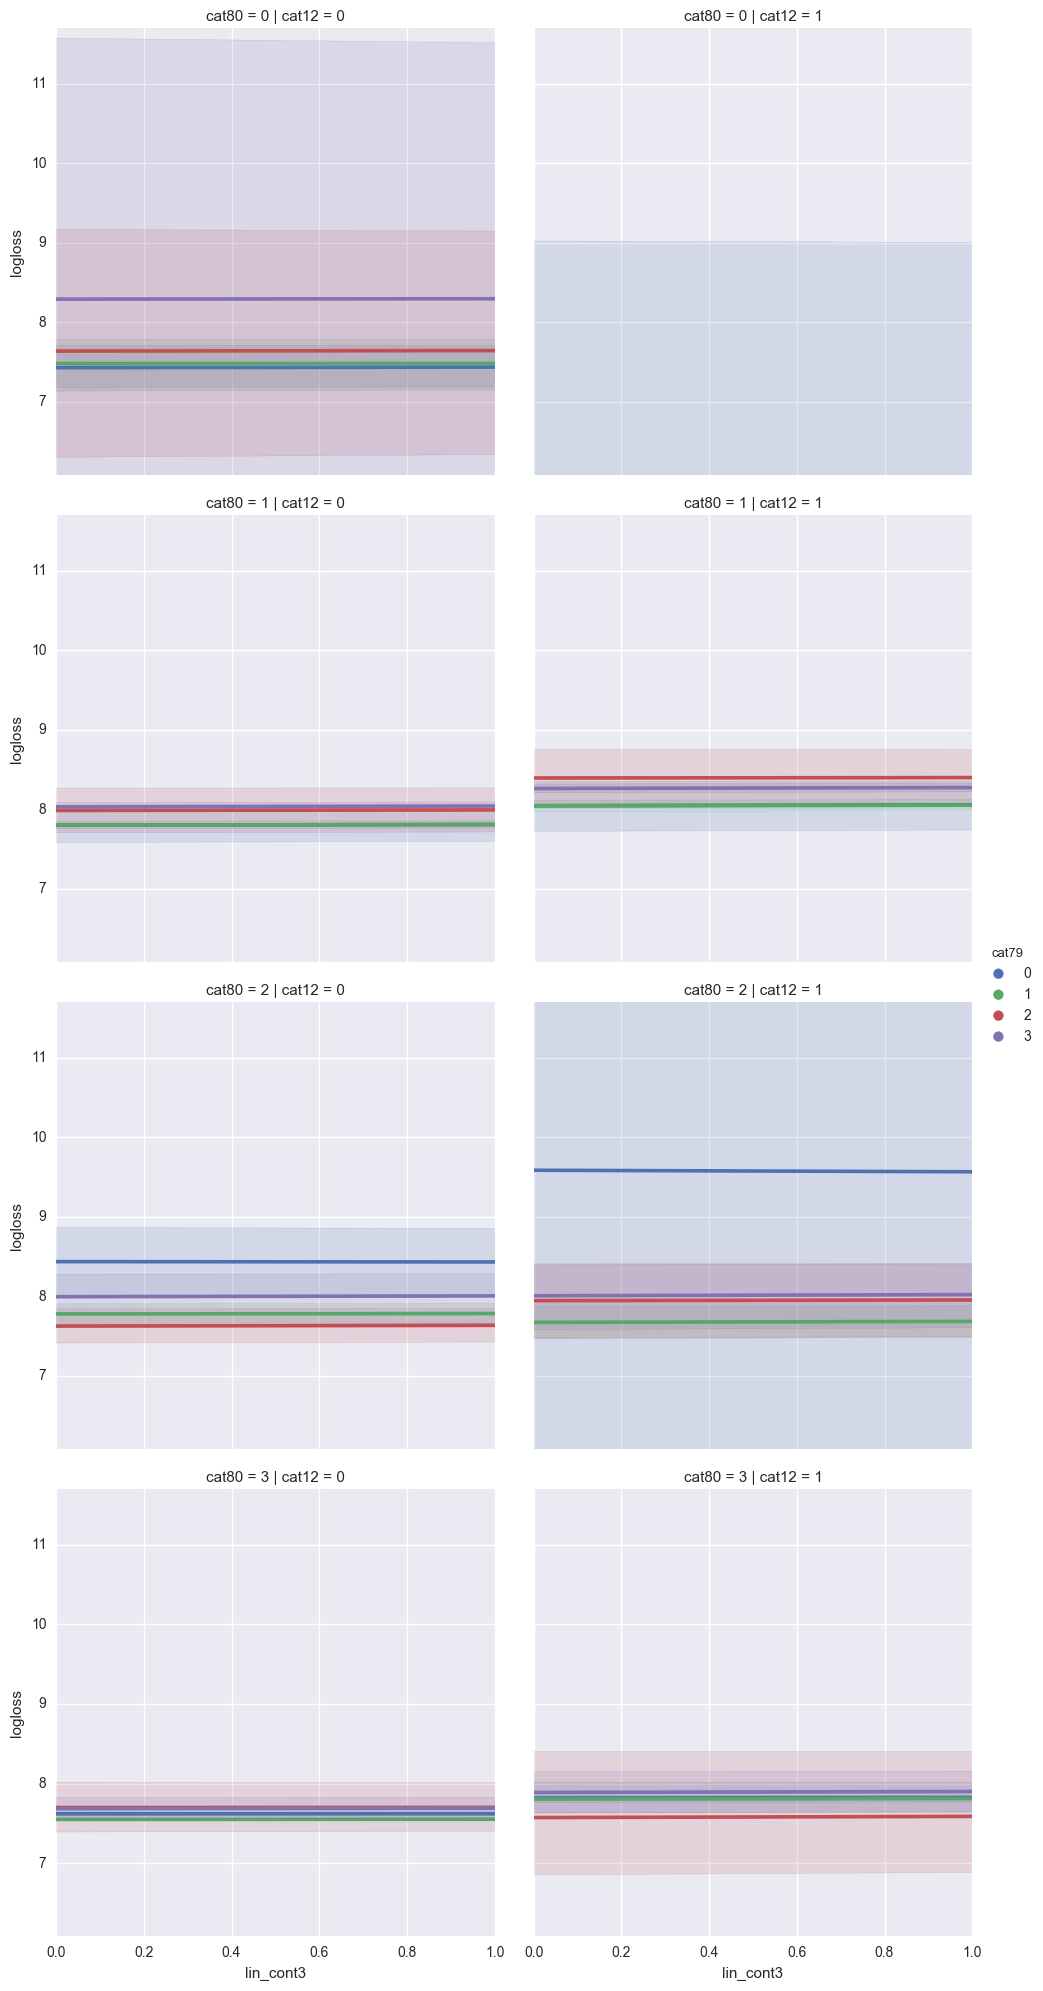

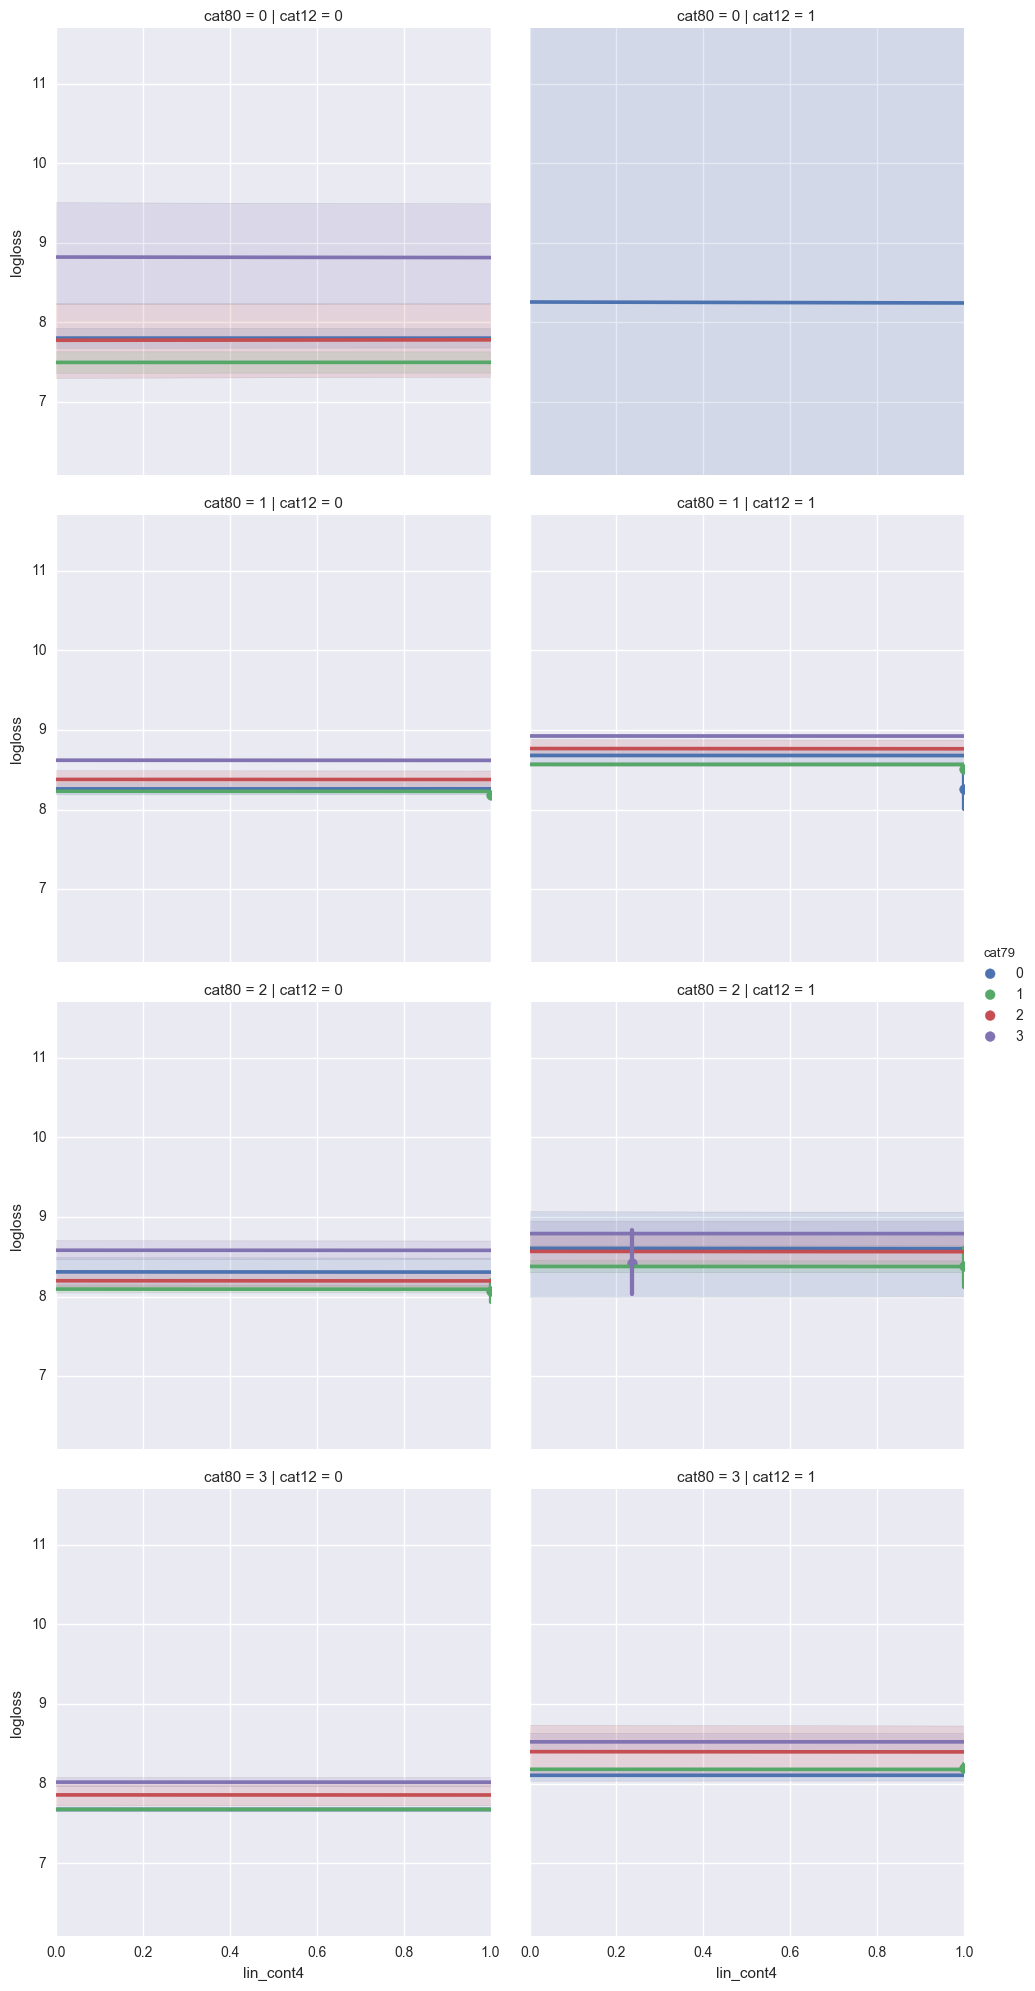

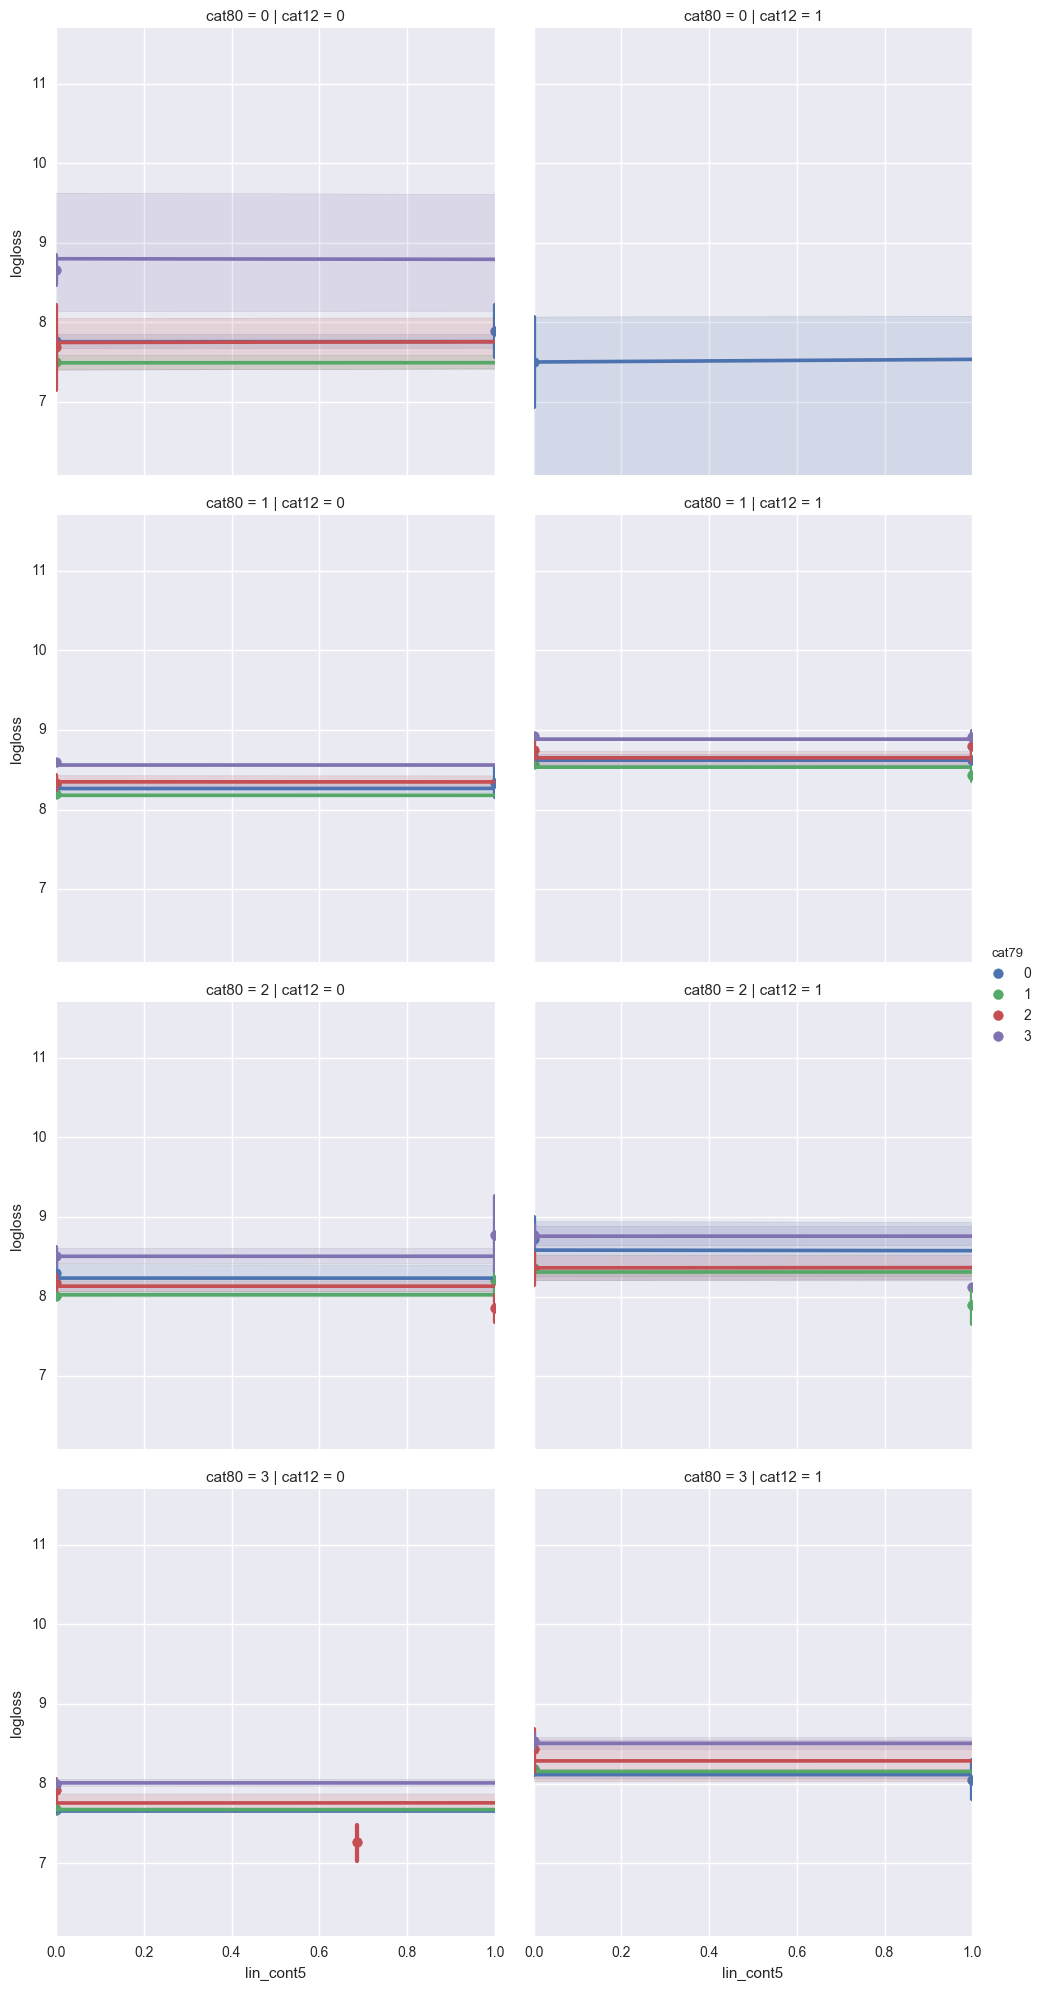

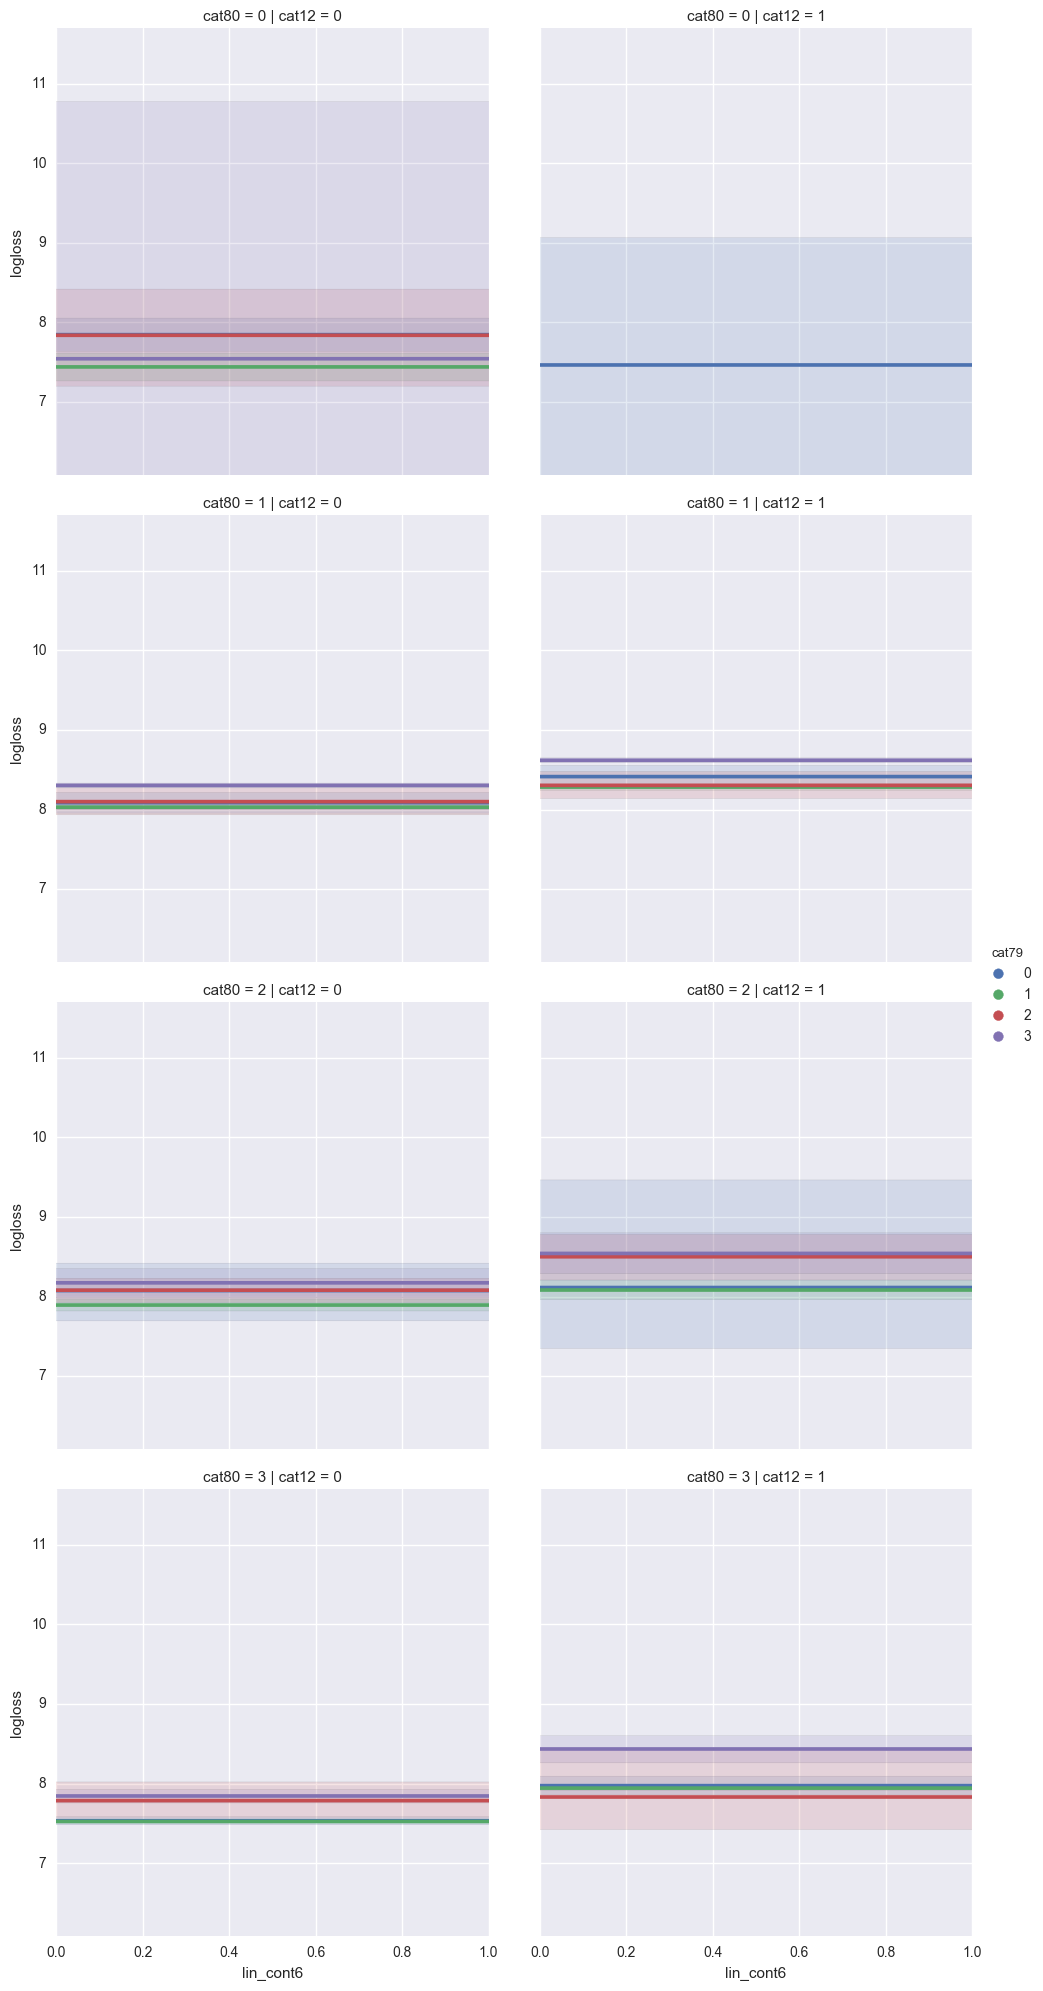

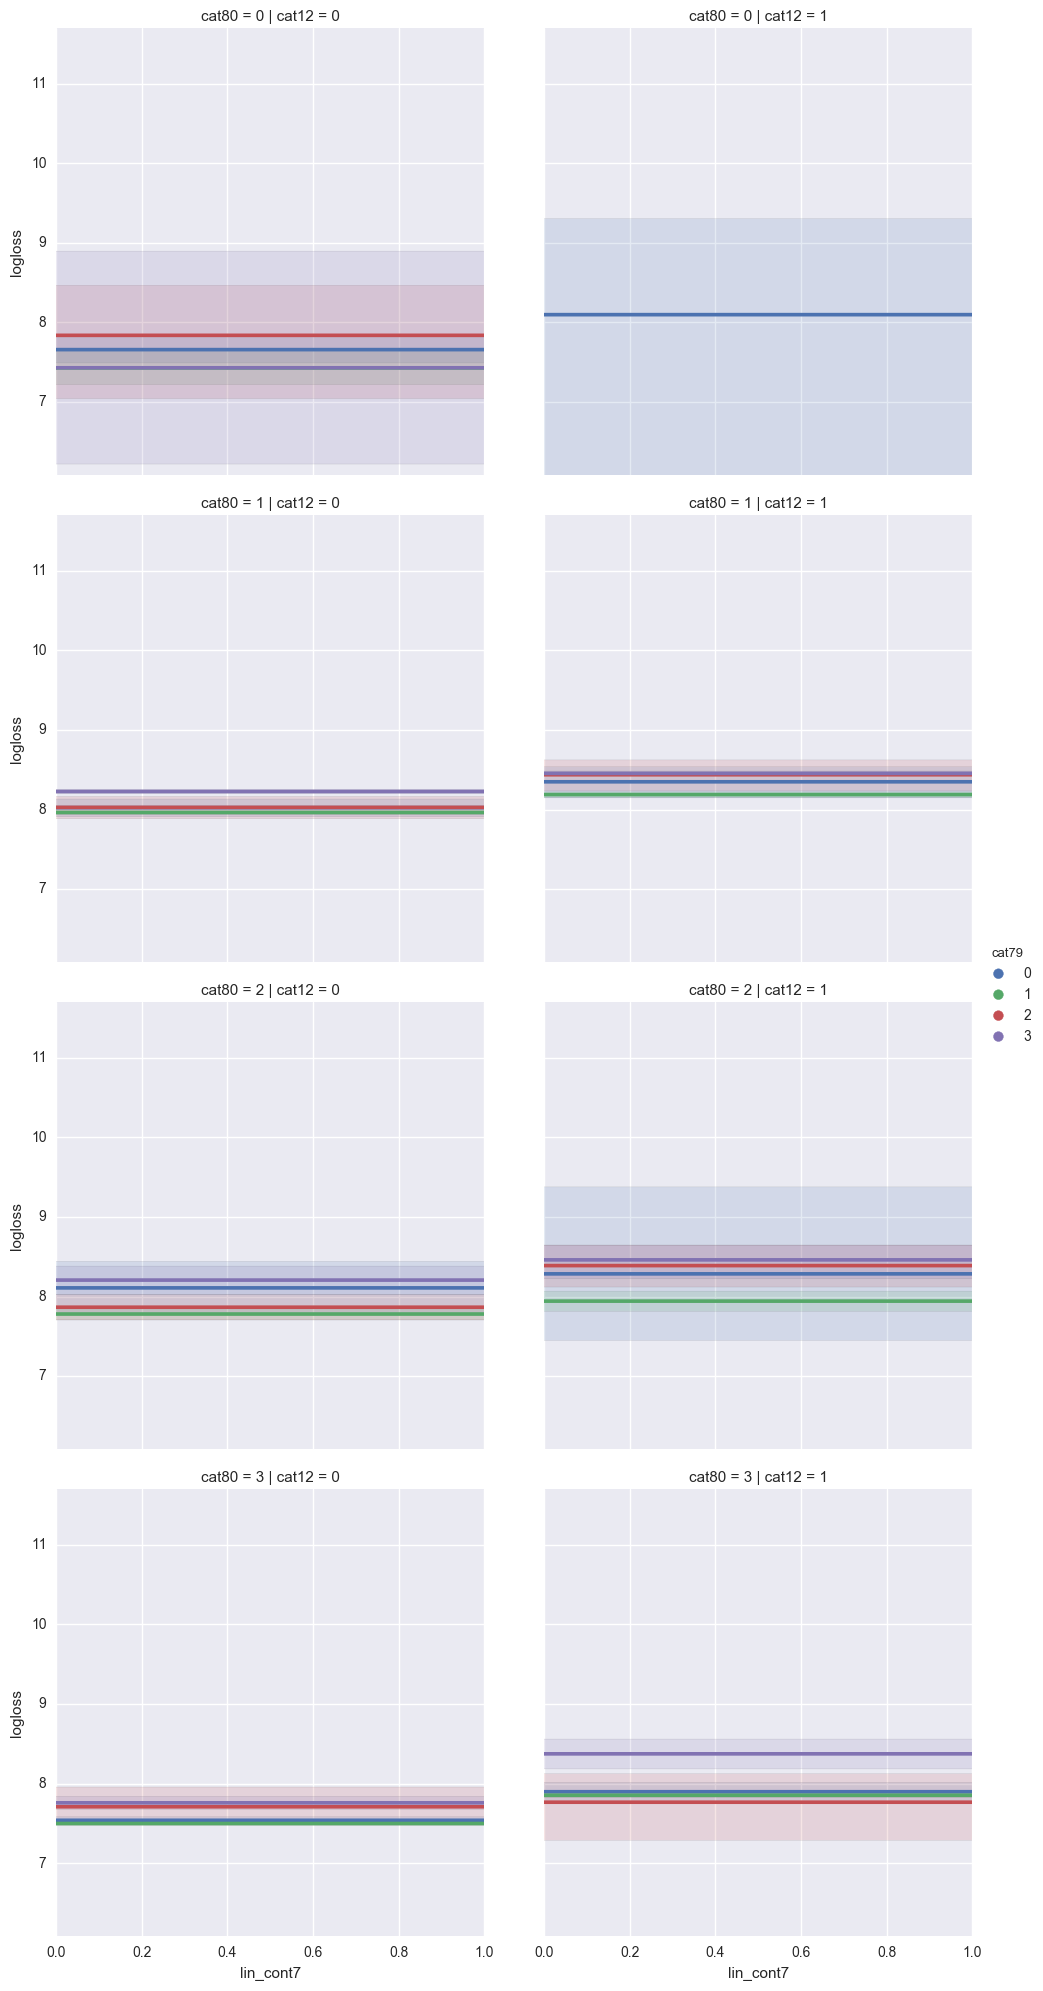

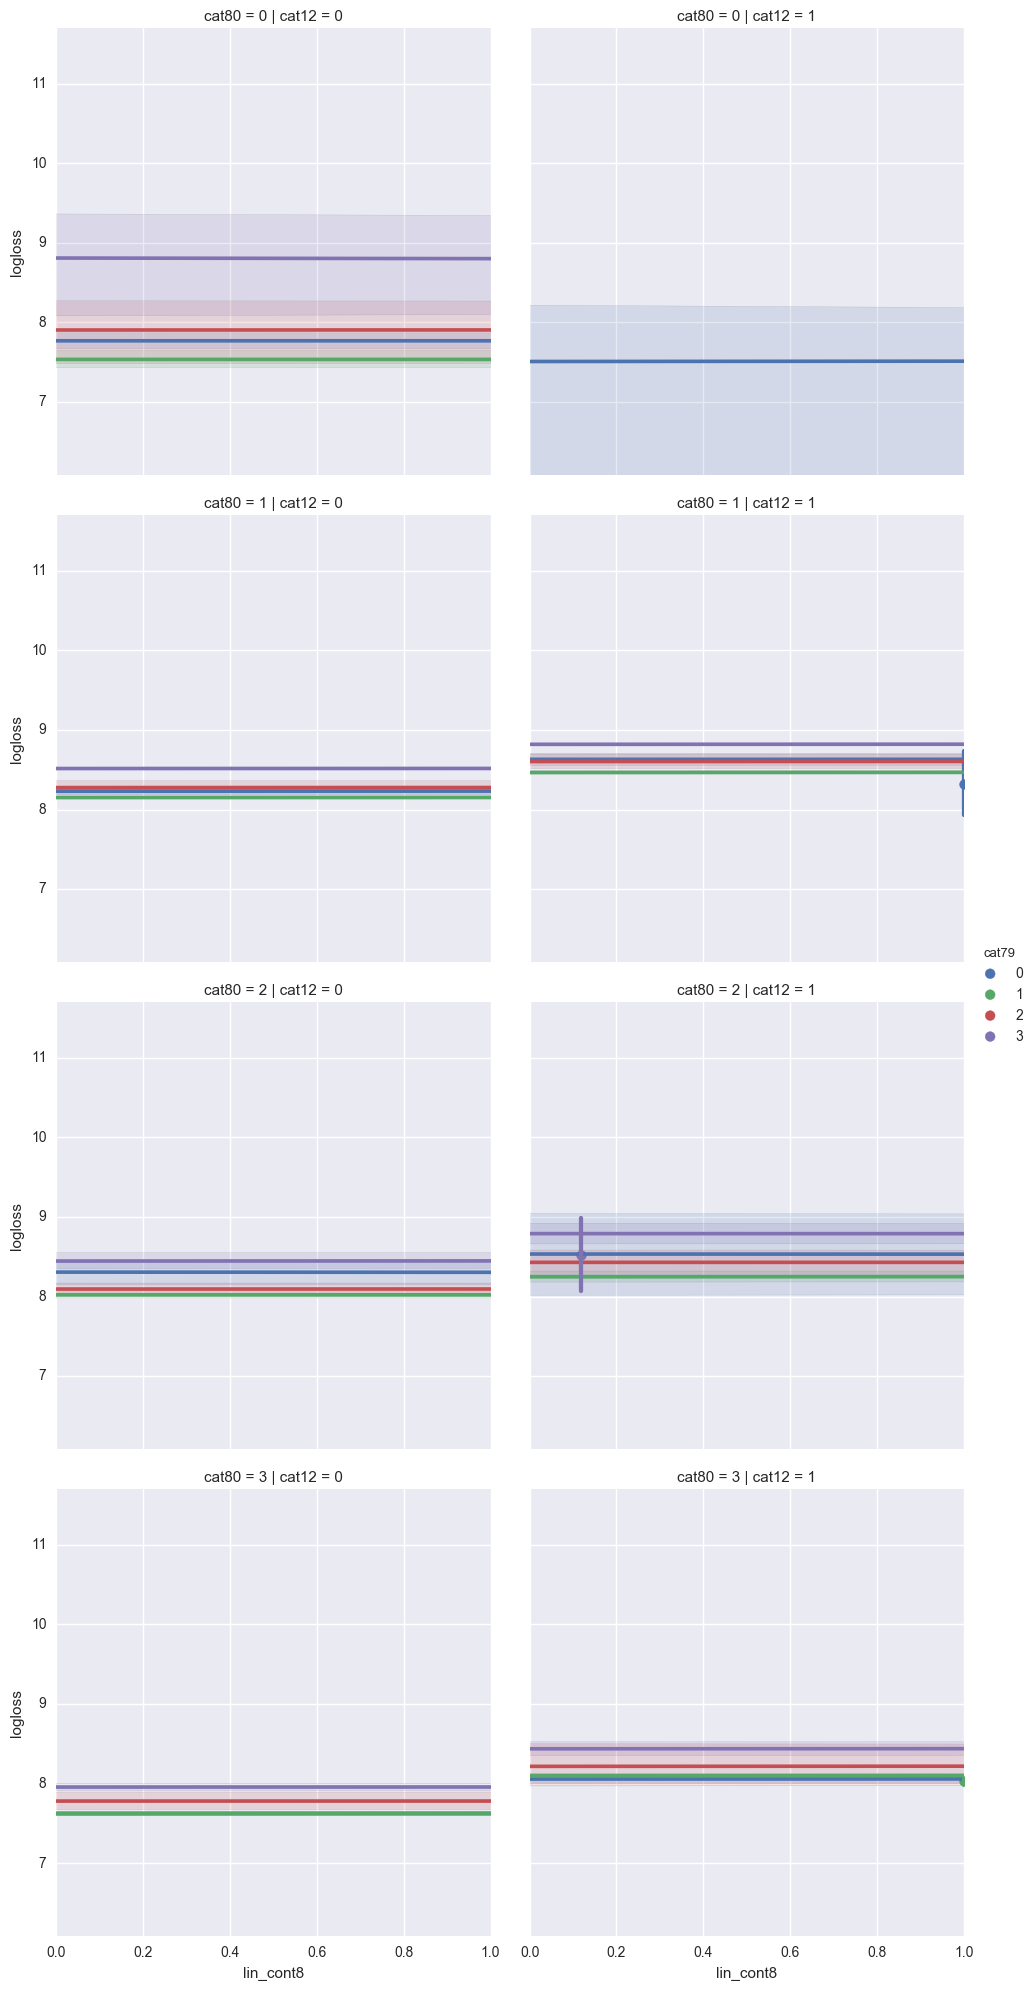

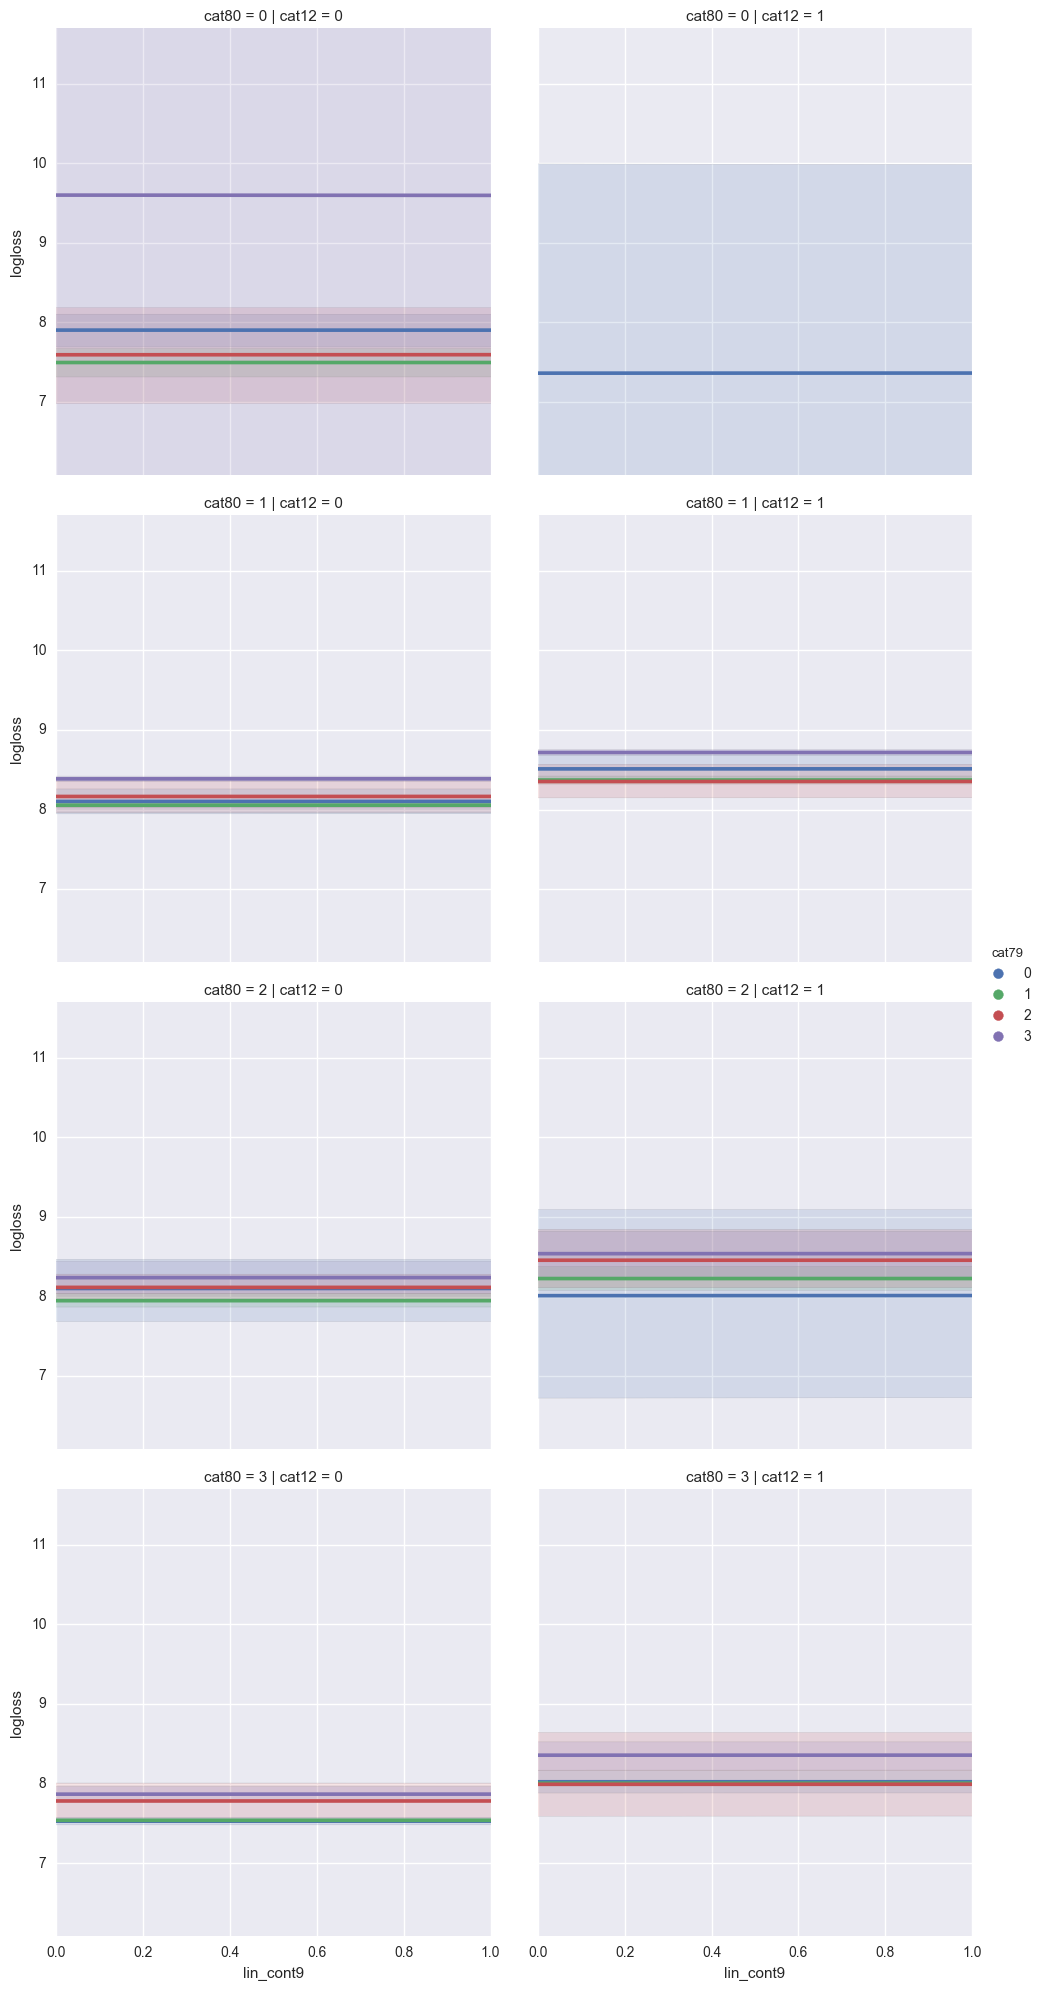

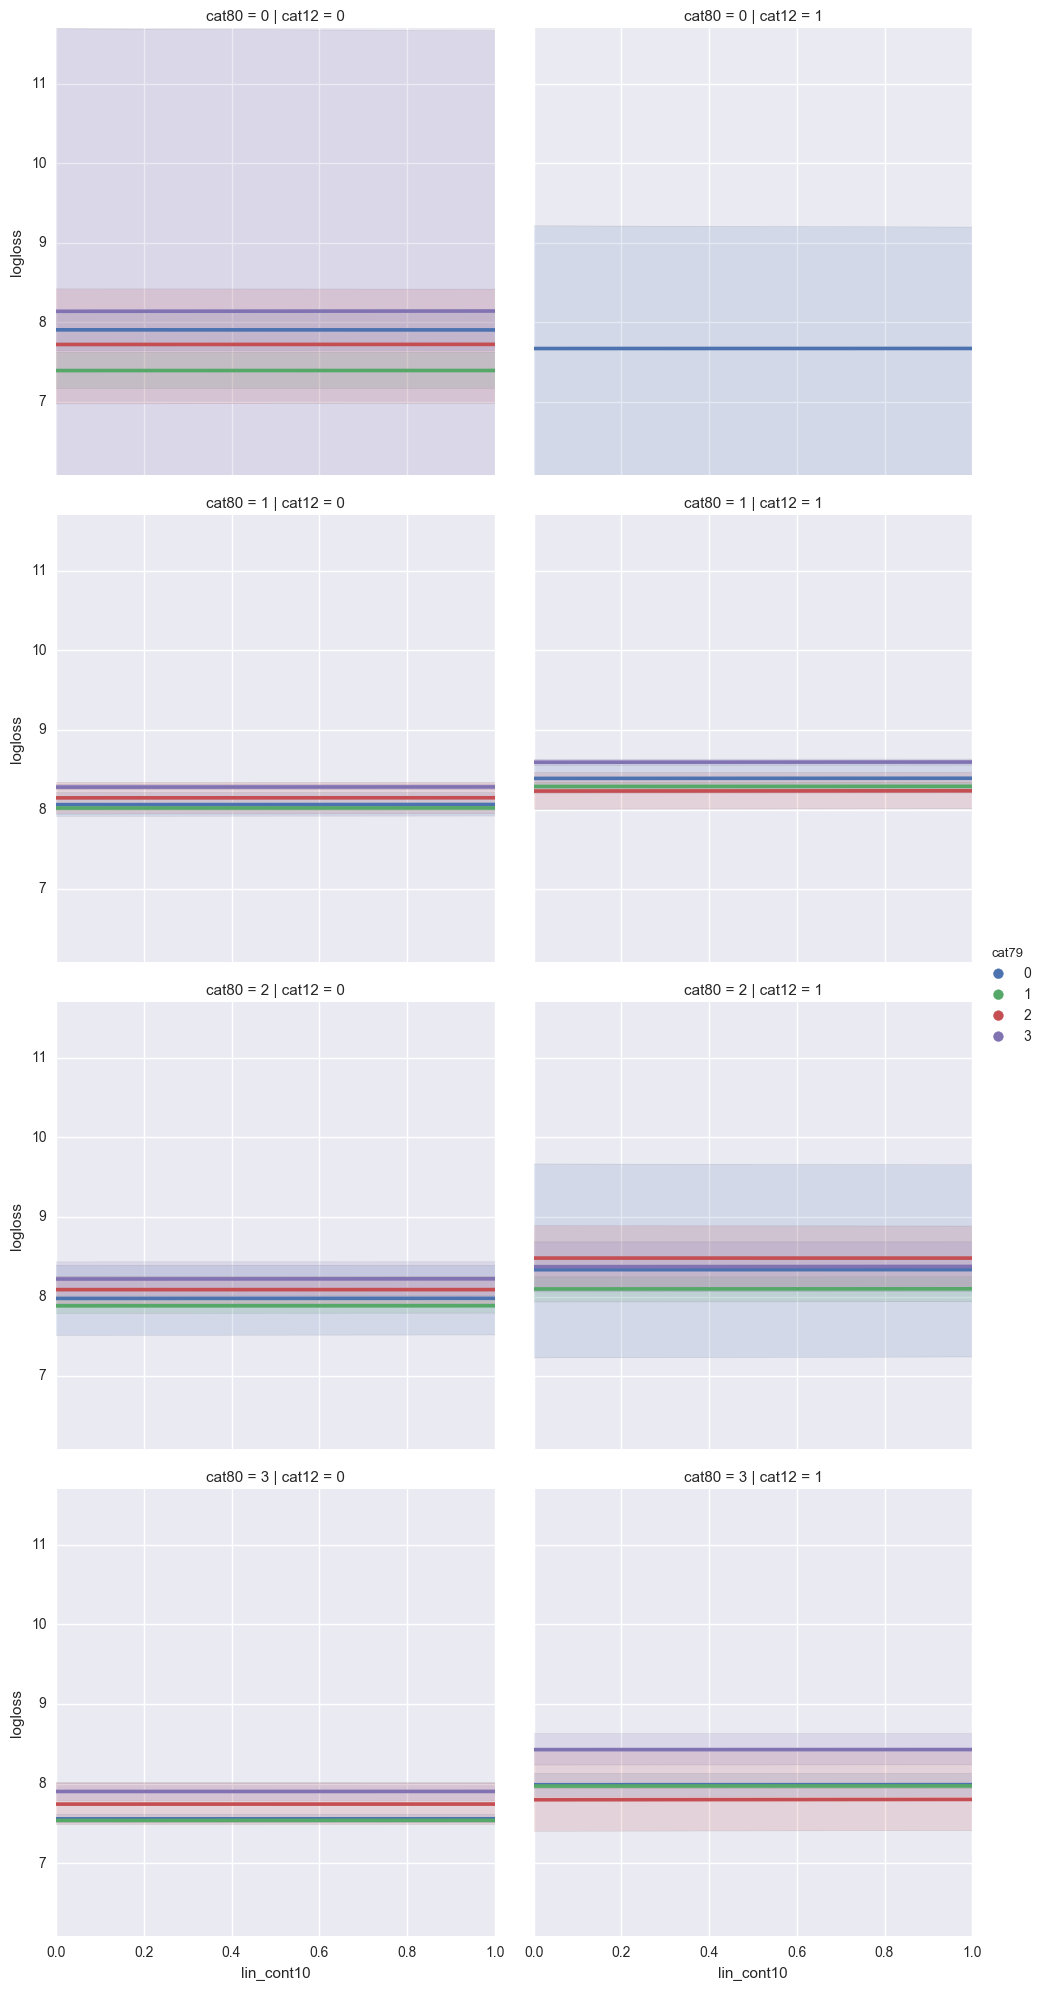

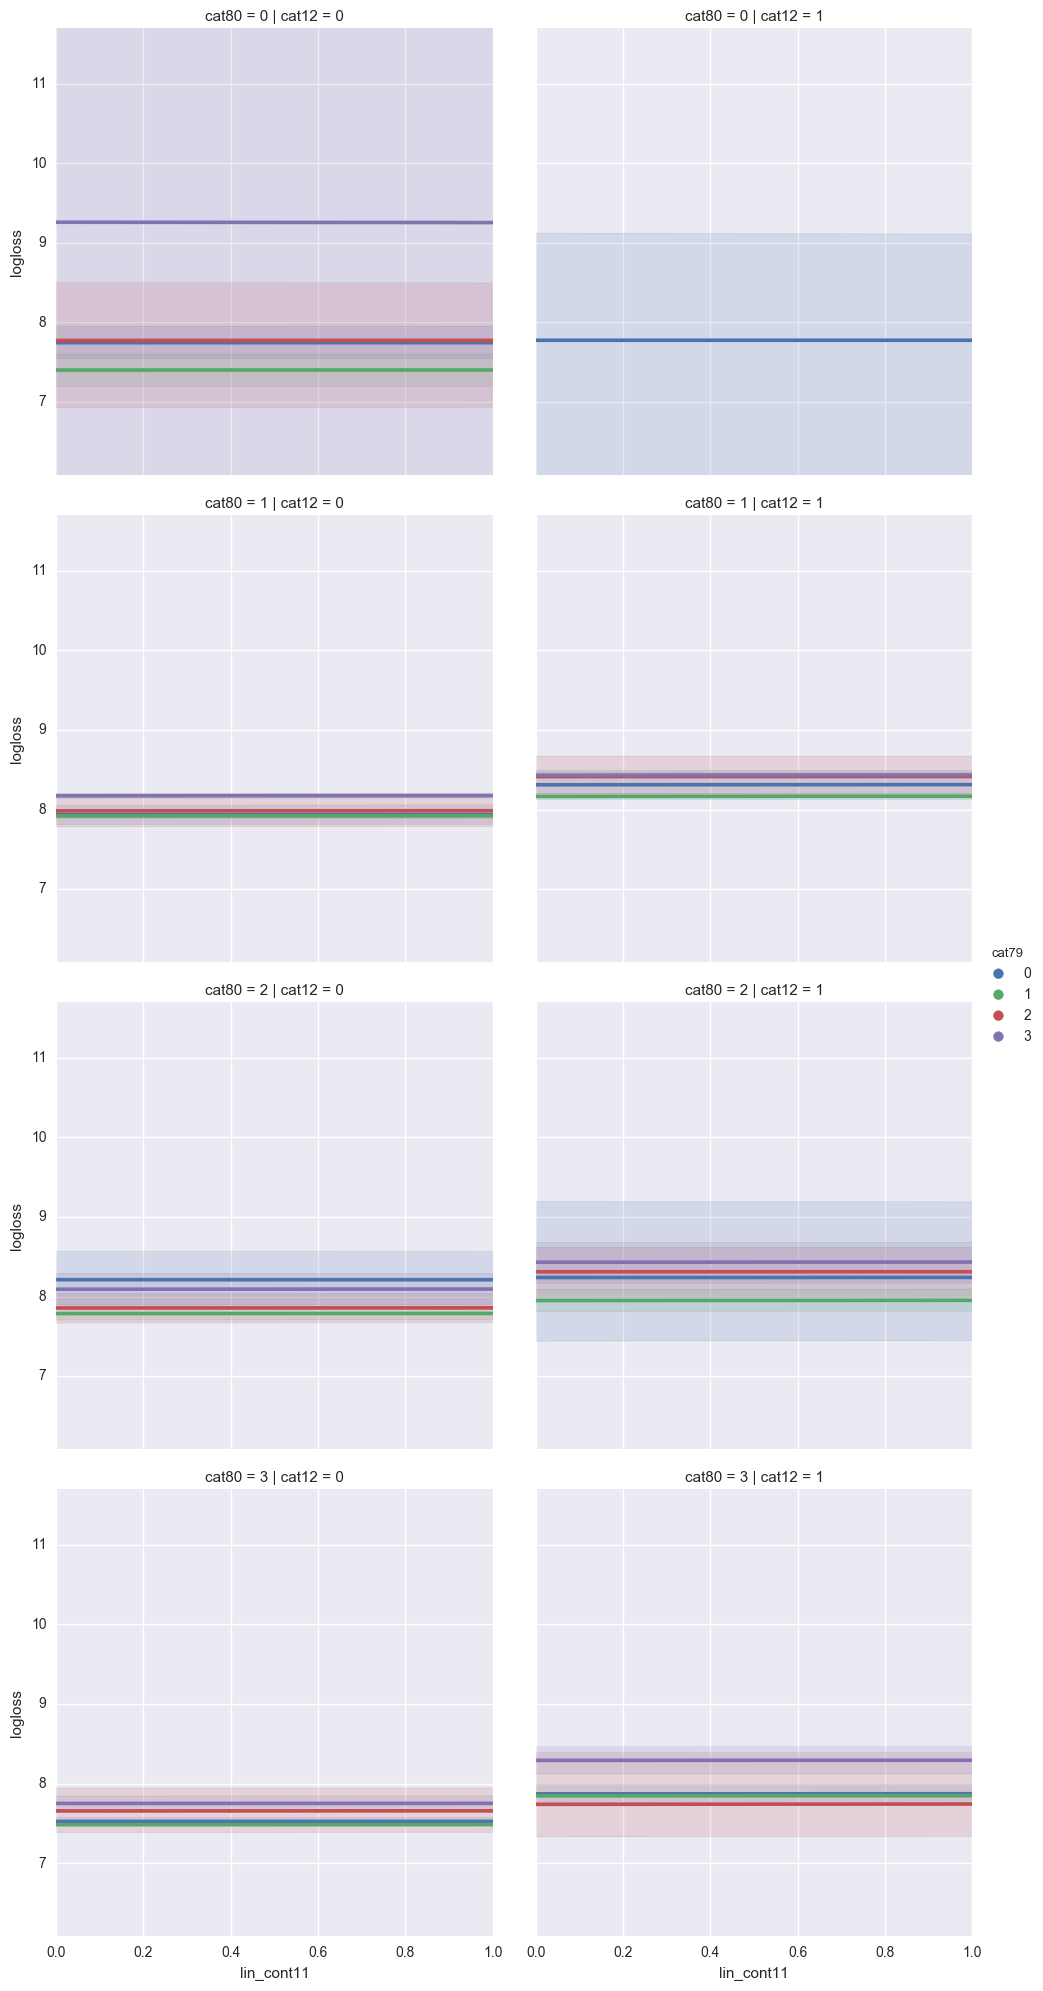

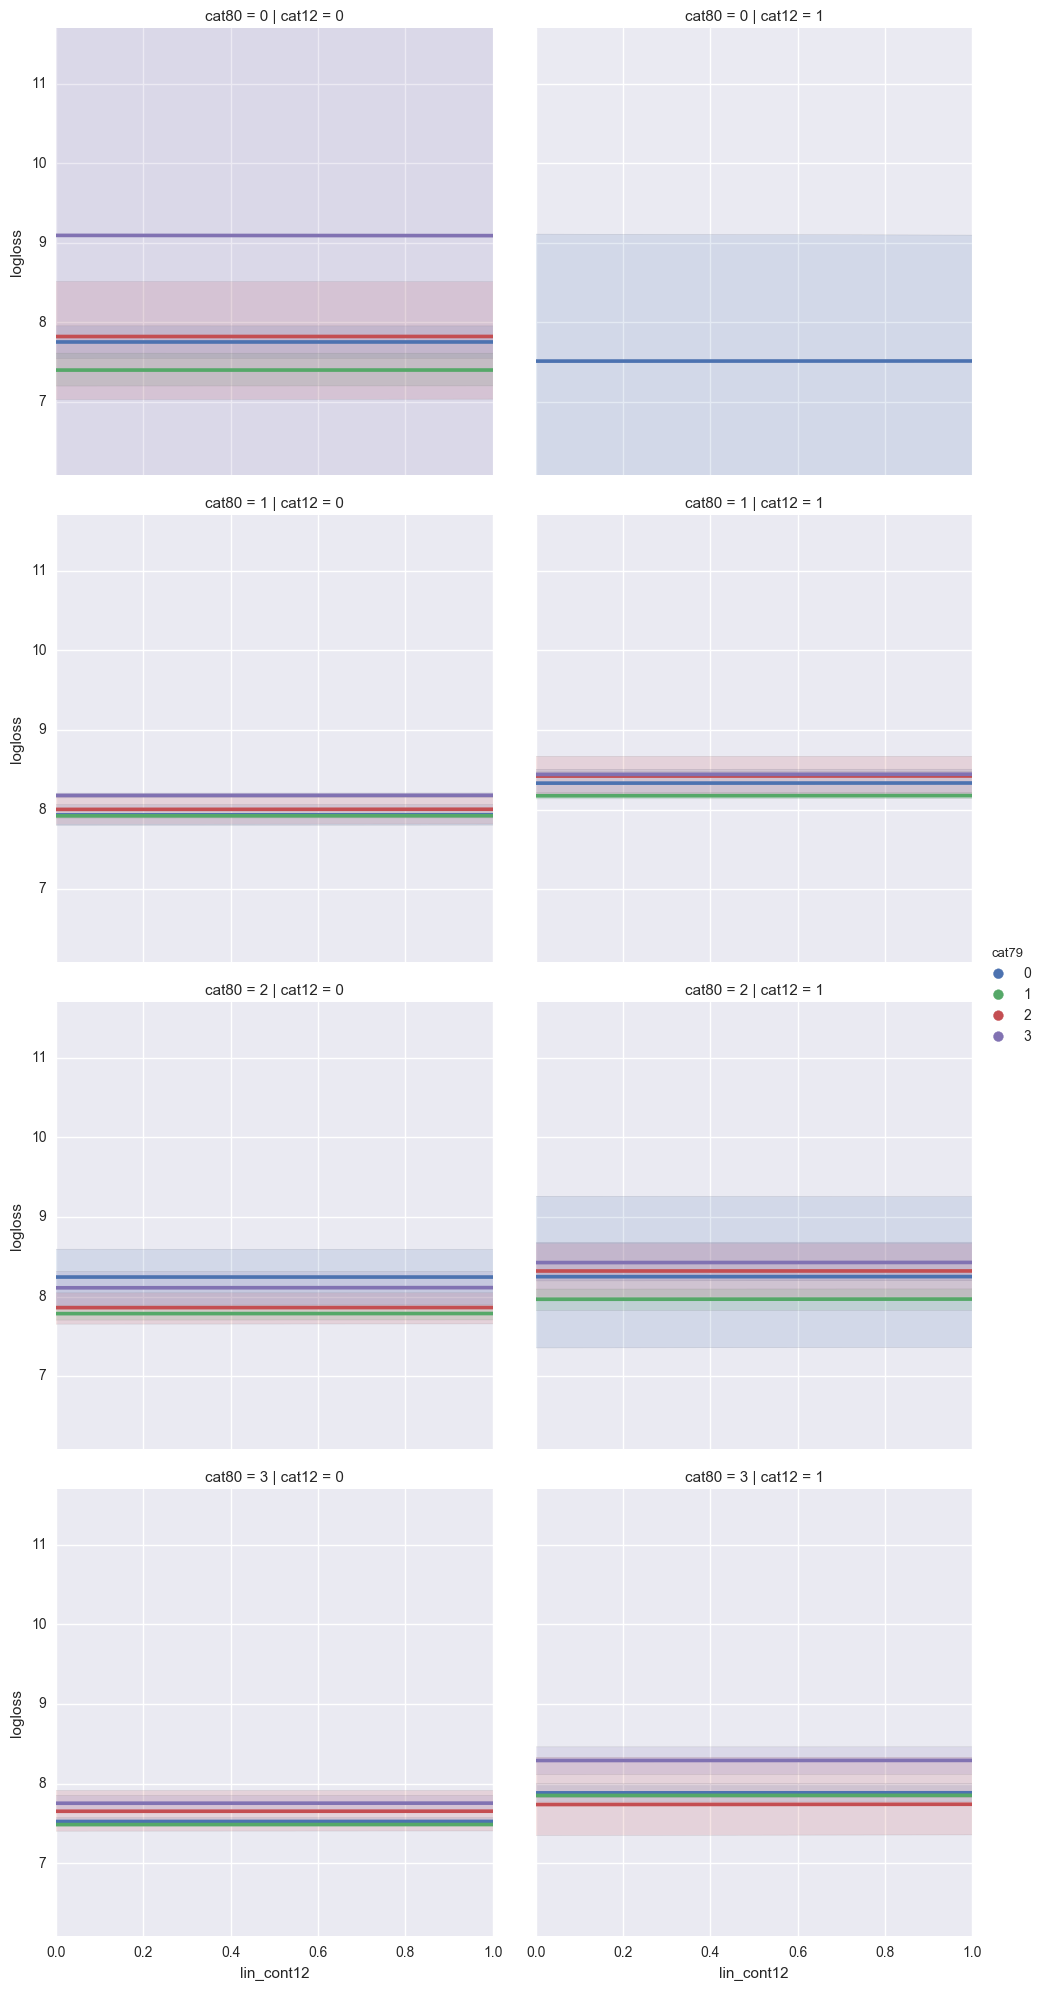

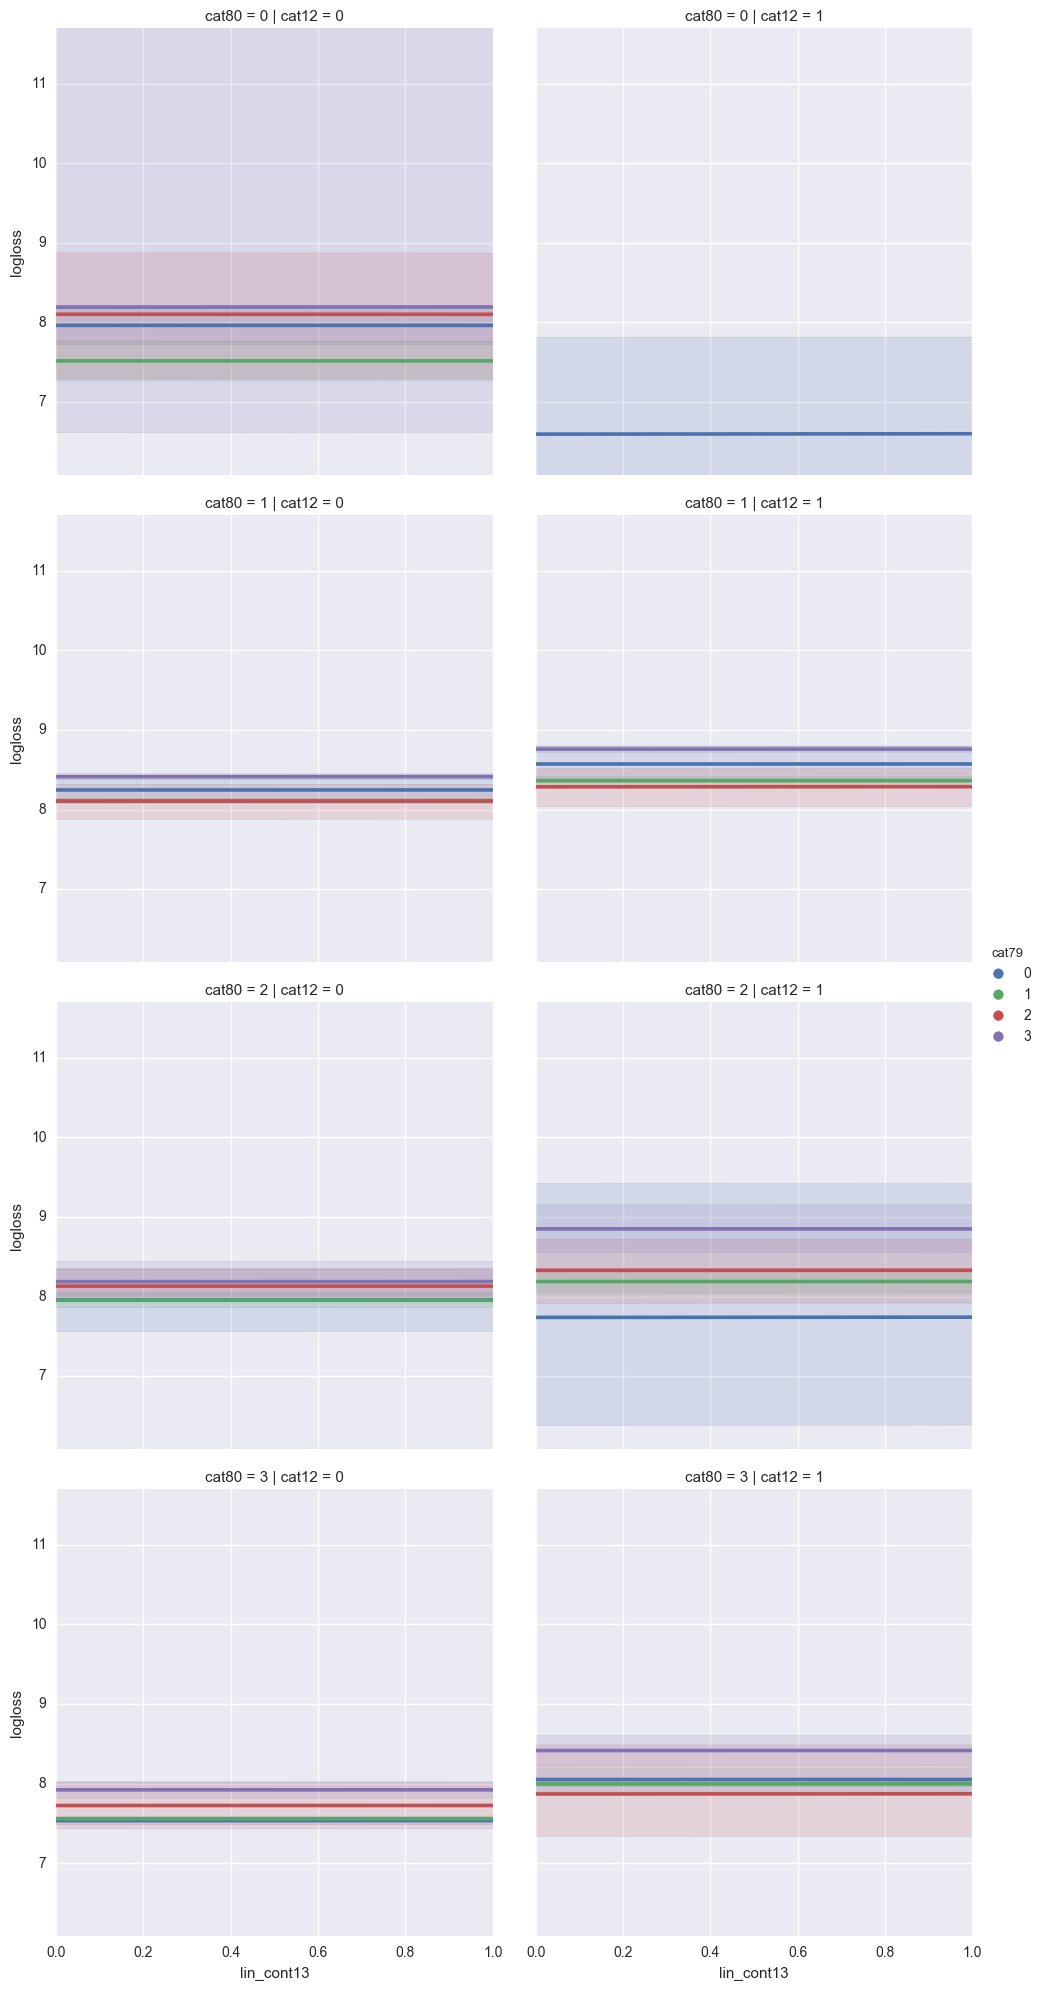

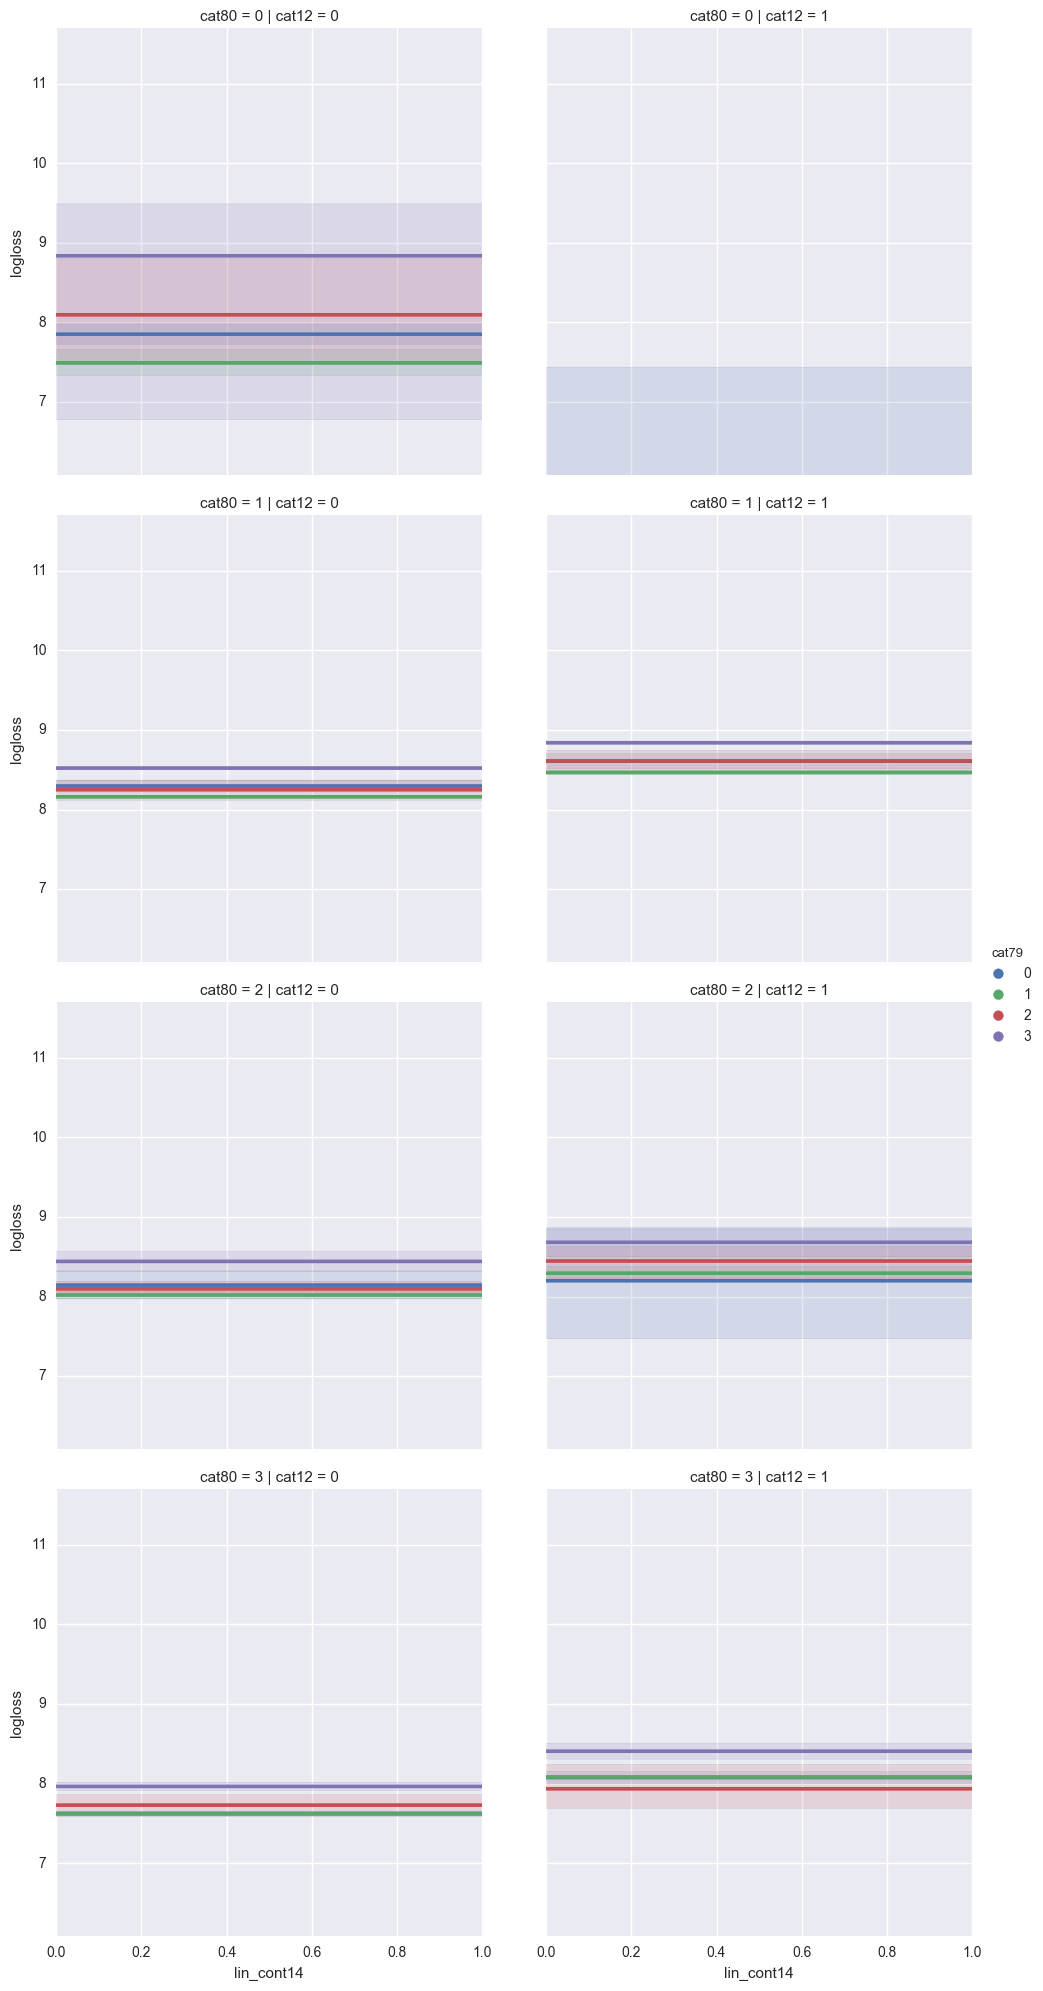

In [7]:
for col in num_feats:
    sns.lmplot(x=col, y='logloss', data=train, 
               hue='cat79', col='cat12', row='cat80', x_bins=50, x_estimator=np.mean, x_ci=90, size=5)
    sns.plt.ylim(train.logloss.min(),train.logloss.max())
    sns.plt.xlim(0,1)